In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from scipy import stats
import os

from scipy import spatial
from scipy import sparse
from scipy.interpolate import CubicSpline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from umap import UMAP

import json

In [2]:
import importlib

from scroutines import powerplots
from scroutines.miscu import is_in_polygon

import utils_merfish
importlib.reload(utils_merfish)
from utils_merfish import rot2d, st_scatter, st_scatter_ax, plot_cluster, binning
from utils_merfish import RefLineSegs

import merfish_datasets
import merfish_genesets
importlib.reload(merfish_datasets)
from merfish_datasets import merfish_datasets
from merfish_datasets import merfish_datasets_params

from scroutines import basicu

In [3]:
def get_qc_metrics(df):
    """
    return metrics
     - key
      - (name, val, medval, bins)
    """
    metrics = {}
    cols  = ['volume', 'gncov', 'gnnum']
    names = ['cell volume', 'num transcripts', 'num genes']
    
    for col, name in zip(cols, names):
        val = df[col].values
        medval = np.median(val)
        bins = np.linspace(0, 10*medval, 50)
        
        metrics[col] = (name, val, medval, bins)
    return metrics

def get_norm_counts(adata, scaling=500):
    """norm - equalize the volume to be 500 for all cells
    """
    cnts = adata.X
    vol = adata.obs['volume'].values
    normcnts = cnts/vol.reshape(-1,1)*scaling
    adata.layers['norm'] = normcnts
    
    return normcnts

In [4]:
def get_largest_spatial_components(adata, k=100, dist_th=80):
    """
    k - number of neighbors
    dist_th - distance to call connected components
    
    returns
        - indices of the largest components
    """
    XY = adata.obs[['x', 'y']].values
    nc = len(XY)

    # kNN
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(XY)
    distances, indices = nbrs.kneighbors(XY)

    # filtered by distance th
    val = distances[:,1:].reshape(-1,)
    i = np.repeat(indices[:,0],k-1)
    j = indices[:,1:].reshape(-1,)

    indices_filtered = np.vstack([i[val < dist_th], j[val < dist_th]]).T

    G = nx.Graph()
    G.add_nodes_from(np.arange(nc))
    G.add_edges_from(indices_filtered)
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    indices_selected = np.array(list(largest_component))

    print(f"fraction of cells included: {len(largest_component)/nc: .2f}" )
    
    return indices_selected, XY

In [5]:
def preprocessing(adata):
    # filter genes
    cond = np.ravel((adata.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
    adata_sub = adata[:,cond]

    # counts
    x = adata_sub.X
    cov = adata_sub.obs['n_counts'].values

    # CP10k
    xn = (sparse.diags(1/cov).dot(x))*1e4

    # log10(CP10k+1)
    xln = xn.copy()
    xln.data = np.log10(xln.data+1)

    adata_sub.layers['norm'] = xn
    adata_sub.layers['lognorm'] = xln
    
    return adata_sub

In [6]:
def get_hvgs(adata, layer, nbin=20, qth=0.3):
    """
    """
    xn = adata.layers[layer]
    
    # min
    gm = np.ravel(xn.mean(axis=0))

    # var
    tmp = xn.copy()
    tmp.data = np.power(tmp.data, 2)
    gv = np.ravel(tmp.mean(axis=0))-gm**2

    # cut 
    lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))
    gres = pd.DataFrame()
    gres['lbl'] = lbl
    gres['mean'] = gm
    gres['var'] = gv
    gres['ratio']= gv/gm

    # select
    gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
    gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)

    assert np.all(gsel_idx != -1)
    
    return adata.var.index.values[gsel_idx]

In [7]:
def neighbor_label_transfer(k, ref_emb, qry_emb, ref_lbl, p_cutoff=0.5, dist_cutoff=None):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(ref_emb)
    dists, idx = neigh.kneighbors(qry_emb, k, return_distance=True)
    
    raw_pred = ref_lbl[idx]

    # p
    pabc = np.empty((qry_n, n_unq_lbls))
    for i, lbl in enumerate(unq_lbls):
        p = np.sum(raw_pred==lbl, axis=1)/k
        pabc[:,i] = p

    # max
    max_pred = unq_lbls[np.argmax(pabc, axis=1)]

    # 
    gated_pred = max_pred.copy()
    cond1 = np.max( pabc, axis=1) > p_cutoff
    gated_pred[~cond1] = 'NA' 
    if dist_cutoff is not None:
        cond2 = np.max(dists, axis=1) < dist_cutoff
        gated_pred[~cond2] = 'NA' 
    
    return max_pred, gated_pred, np.max(dists, axis=1)


def neighbor_self_nonself(k, ref_emb, qry_emb):
    """ref vs qry neighbors
    """
    unq_lbls = np.unique(ref_lbl).astype(str) # array(['L2/3_A', 'L2/3_B', 'L2/3_C'])
    n_unq_lbls = len(unq_lbls)
    ref_n = len(ref_emb)
    qry_n = len(qry_emb)
    lbls = np.array([0]*ref_n+[1]*qry_n)
    
    neigh = NearestNeighbors(n_neighbors=k) # , radius=0.4)
    neigh.fit(np.vstack([ref_emb, qry_emb]))
    idx = neigh.kneighbors(qry_emb, k, return_distance=False)
    
    isself = lbls[idx]

    p = np.sum(isself, axis=1)/k

    
    return p # max_pred, gated_pred, np.max(dists, axis=1)

# load data and construct adata 

In [8]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240718"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized"
!mkdir -p $outdir
!mkdir -p $outdatadir

In [9]:
outfigdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2"
!mkdir -p $outfigdir
fig_manager = powerplots.FigManager(outfigdir)

/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2


In [10]:
np.random.seed(0)

In [11]:
genesets, df = merfish_genesets.get_all_genesets()
for key, item in genesets.items():
    print(key, len(item))

allmerfish 500
a 64
b 35
c 71
i 16
a_up 14


In [12]:
ddir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized" 
# fout = os.path.join(ddir, 'P28NRDR_v1_rna_merfish_240729.h5ad')
# fout2 = os.path.join(ddir, 'P28NRDR_v1glut_rna_merfish_240729.h5ad')
# fout3 = os.path.join(ddir, 'P28NRDR_v1l23glut_rna_merfish_240729.h5ad')
!ls $ddir/*l0*240723.h5ad 

/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28DRa_ant_l0_hemibrain_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28DRa_pos_l0_hemibrain_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28DRb_ant_l0_hemibrain_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28DRb_pos_l0_hemibrain_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRa_ant_l0_hemibrain_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRa_pos_l0_hemibrain_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRb_ant_l0_hemibrain_240723.h5ad
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRb_pos_l0_hemibrain_240723.h5ad


In [13]:
%%time
names = [
    'P28NRa_ant', 
    'P28NRa_pos',
    
    'P28NRb_ant', 
    'P28NRb_pos',
    
    'P28DRa_ant', 
    'P28DRa_pos',
    
    'P28DRb_ant', 
    'P28DRb_pos',
]

name_signs = [-1,1,-1,-1,-1,-1,1,1]

alldata = {}
alldata_meta = {}
for i, name in enumerate(names):
    adatasub = ad.read(os.path.join(ddir, f'{name}_l1_wholecortex_240723.h5ad')) 
    adatasub.obs.index = np.char.add(f'{name}', adatasub.obs.index.values)
    alldata[name] = adatasub 
    
    l, r = ad.read(os.path.join(ddir, f'{name}_l2_v1_240723.h5ad'), backed='r').uns['v1_window'] 
    
    sign = name_signs[i]
    alldata_meta[name] = (sign, l, r)
    
    
genes = adatasub.var.index.values
genes.shape

CPU times: user 2.28 s, sys: 4.54 s, total: 6.82 s
Wall time: 58.3 s


(500,)

In [14]:
alldata_meta

{'P28NRa_ant': (-1, 6000, 7100),
 'P28NRa_pos': (1, 1500, 3300),
 'P28NRb_ant': (-1, 5400, 6400),
 'P28NRb_pos': (-1, 5700, 7700),
 'P28DRa_ant': (-1, 5700, 7700),
 'P28DRa_pos': (-1, 5300, 7300),
 'P28DRb_ant': (1, 1200, 2800),
 'P28DRb_pos': (1, 1000, 3000)}

In [15]:
agenes = genesets['a']
bgenes = genesets['b']
cgenes = genesets['c']
iegs   = genesets['i']
abcgenes = np.hstack([agenes, bgenes, cgenes])
genes_noniegs = np.array([g for g in genes if g not in iegs])

marker_genes = [
       'Ptprn', 'Slc17a7', 'Gad1', 'Fos', 
       
       'Gfap', 'Slc6a13', 'Slc47a1',
       'Grin2c', 'Aqp4', 'Rfx4', 'Sox21', 'Slc1a3',
       
       'Sox10', 'Pdgfra', 'Mog',
       
       'Pecam1', 'Cd34' , 'Tnfrsf12a', 'Sema3c', 
       'Zfhx3', 'Pag1', 'Slco2b1', 'Cx3cr1',
      ] 
len(abcgenes), len(genes_noniegs), len(iegs)

(170, 484, 16)

In [16]:
agenes_idx = basicu.get_index_from_array(adatasub.var.index.values, agenes)
bgenes_idx = basicu.get_index_from_array(adatasub.var.index.values, bgenes)
cgenes_idx = basicu.get_index_from_array(adatasub.var.index.values, cgenes)
igenes_idx = basicu.get_index_from_array(adatasub.var.index.values, iegs)

In [17]:
mean_total_rna_target = 250
adata_merged = []
for i0, name in enumerate(names):
    
    j = i0 // 4
    i = i0 % 4
    
    sign, l, r = alldata_meta[name]
    adatasub = alldata[name].copy()
    adatasub.obs['sample'] = name
    
    norm_cnts = adatasub.layers['norm']
    # mean_per_batch = np.mean(norm_cnts.sum(axis=1))
    mean_per_batch_noniegs = np.mean(adatasub[:,genes_noniegs].layers['norm'].sum(axis=1))
    
    adatasub.layers['jnorm']  = norm_cnts*(mean_total_rna_target/mean_per_batch_noniegs)
    adatasub.layers['ljnorm'] = np.log2(1+adatasub.layers['jnorm'])
    
    adatasub.obs['norm_transcript_count']  = adatasub.layers['norm'].sum(axis=1)
    adatasub.obs['jnorm_transcript_count'] = adatasub.layers['jnorm'].sum(axis=1)
    
    d = adatasub.obs['depth'].values
    w = adatasub.obs['width'].values
    
    w1 = sign*w
    l1 = min(sign*l, sign*r)
    r1 = max(sign*l, sign*r)
    
    adatasub.obs['depth_show'] = -d-i*1300 # name
    adatasub.obs['width_show'] =  w1-np.min(w1)+j*15000   # name
    
    adatasub.obs['depth_show2'] = -d-i0*1300 # name
    adatasub.obs['width_show2'] =  (w1-l1)/(r1-l1)*2000   # name
    
    adatasub.obs['width_norm']  =  (w1-l1)/(r1-l1)        # name
    
    adata_merged.append(adatasub)
    
adata_merged = ad.concat(adata_merged)

In [18]:
adata_merged_ctx = adata_merged[adata_merged.obs['depth']<1000]

In [19]:
# find the original code for xxx - where is xxx
adata = adata_merged_ctx

# IEGs

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/1_2024-09-10.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/1.pdf


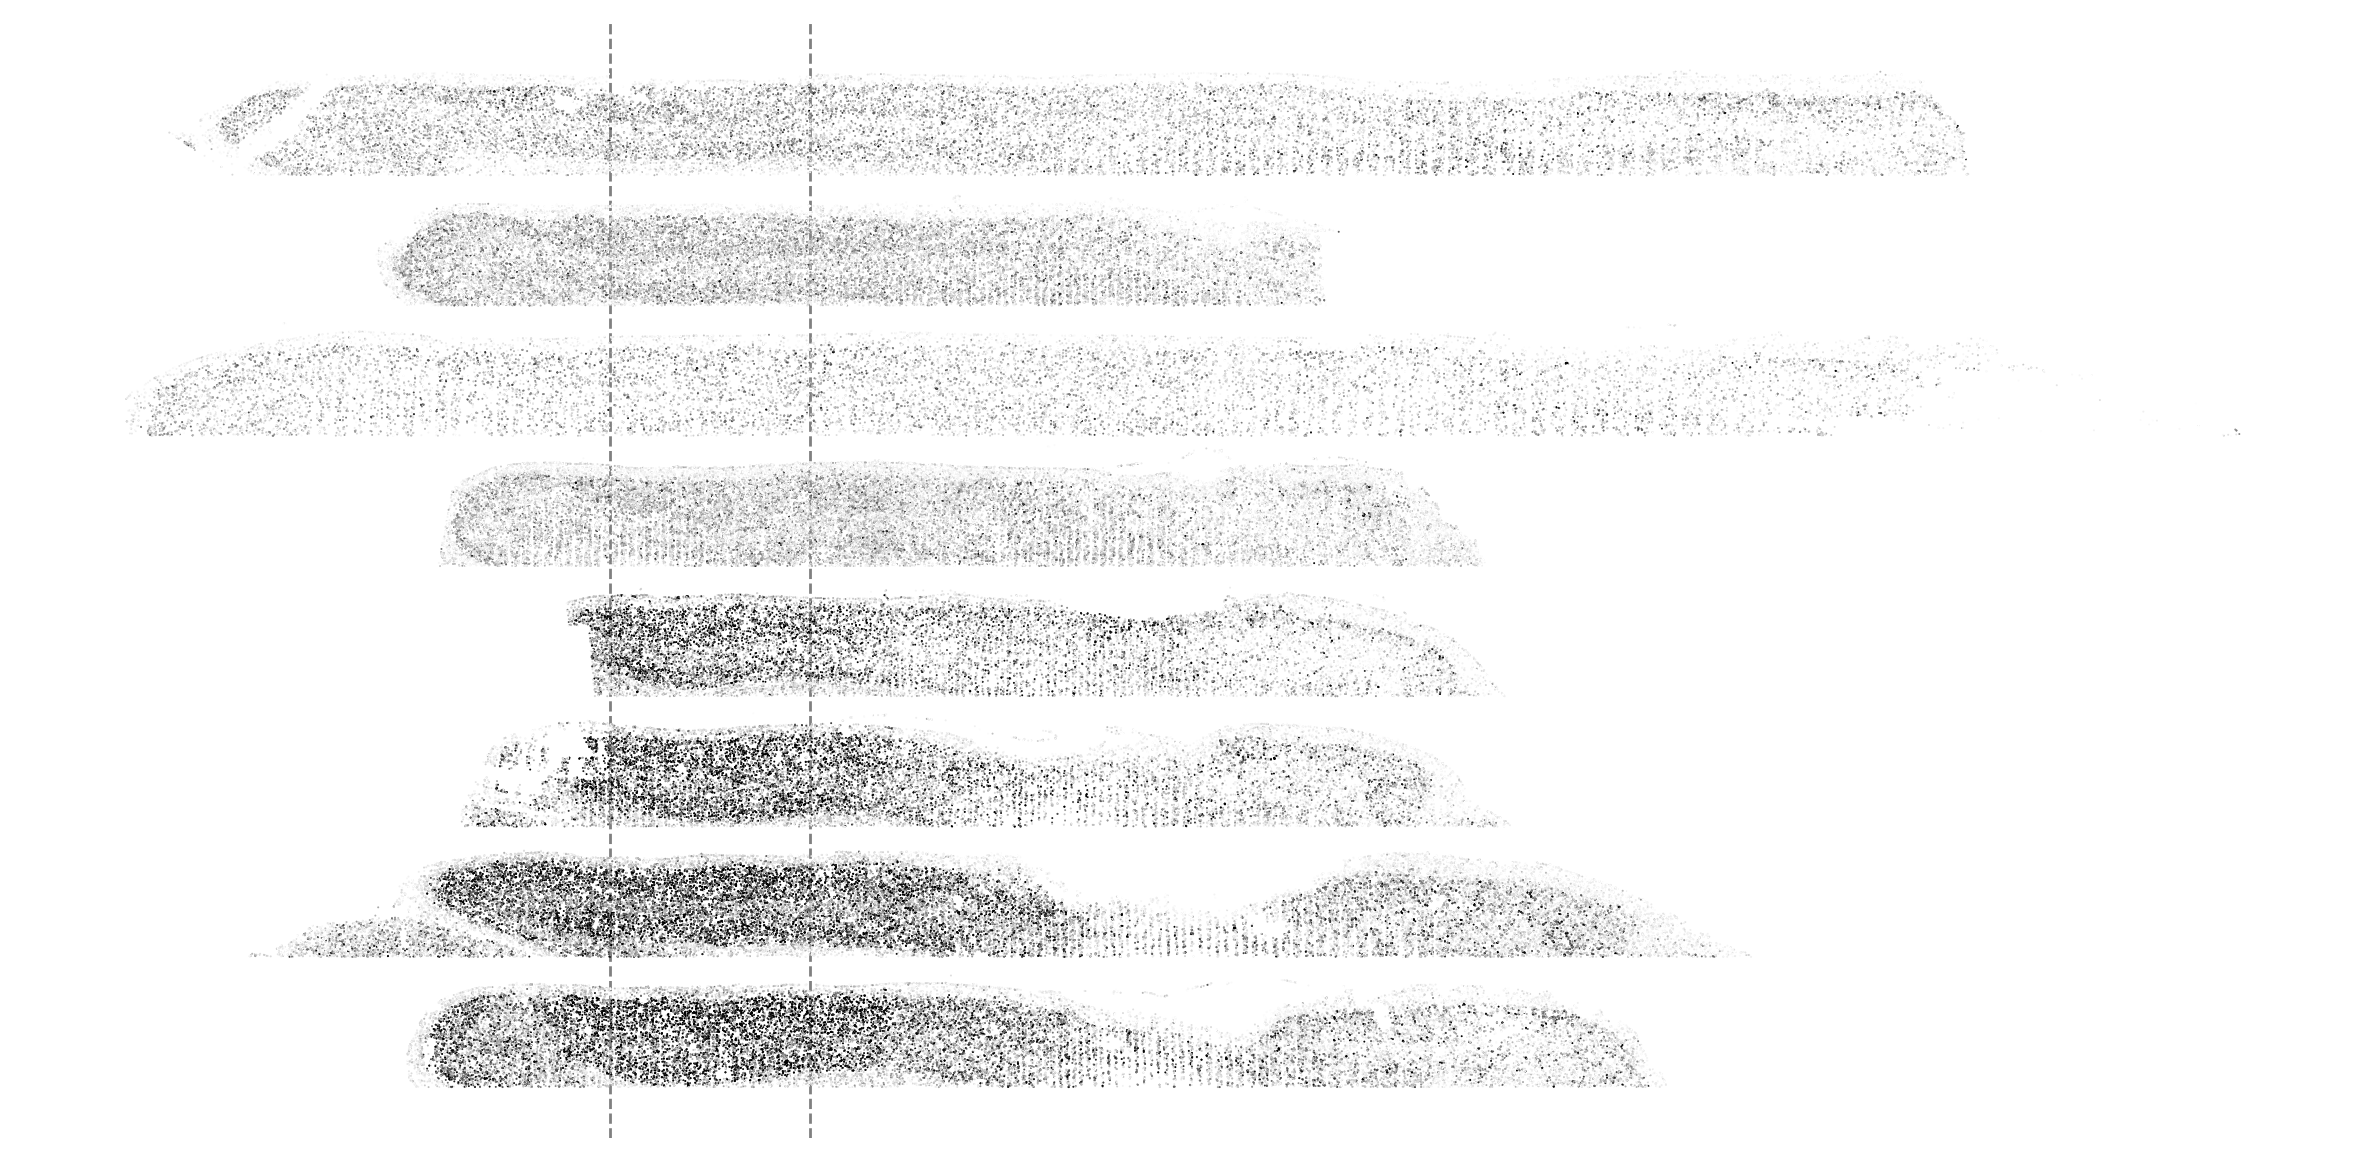

In [20]:
adata_plot = adata

with sns.axes_style('white'): 
    fig, ax = plt.subplots(1,1,figsize=(15,20))
    
    c    =  np.mean(stats.zscore(np.array(adata_plot[:,iegs].layers['ljnorm']), axis=0), axis=1)
    # adata_plot.obsm['c'] = c
    vmax = np.percentile(c,95)
    vmin = np.percentile(c, 5)
    
    x = adata_plot.obs['width_show2']
    y = adata_plot.obs['depth_show2']
    # sorting = np.argsort(c)
    
    
    # ax.scatter(x[sorting], y[sorting], c=c[sorting], s=0.5, edgecolor='none', vmax=vmax, cmap='coolwarm')
    ax.scatter(x, y, c=c, s=0.5, edgecolor='none', vmax=vmax, cmap='gray_r', rasterized=True)
    ax.set_aspect('equal')
    
    # ax.axvline(-2000, color='gray')
    ax.axvline(    0, color='gray', zorder=0, linestyle='--', linewidth=1)
    ax.axvline( 2000, color='gray', zorder=0, linestyle='--', linewidth=1)
    # ax.axvline( 4000, color='gray')
    # ax.axvline( 6000, color='gray')
    ax.axis('off')
    
    fig_manager.savefig(fig)
    plt.show()

# quantification

In [21]:
def binning_pipe2(adata, col_to_bin, layer, bins=None, n=20):
    """
    """
    if bins is None:
        # bin it 
        bins, binned = utils_merfish.binning(adata.obs[col_to_bin].values, n)
    else:
        binned = pd.cut(adata.obs[col_to_bin].values, bins=bins)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['thebin'] = binned
    
    norm_mean = norm_.groupby('thebin').mean(numeric_only=True)
    norm_sem  = norm_.groupby('thebin').sem(numeric_only=True)
    norm_std  = norm_.groupby('thebin').std(numeric_only=True)
    norm_n    = norm_['thebin'].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, binned, bins 

In [22]:
colors = [
    'C1',
    'C1',
    'C1',
    'C1',
    # sns.color_palette('tab20c')[4],
    # sns.color_palette('tab20c')[5],
    'k',
    'k',
    'k',
    'k',
    # 'gray',
]

In [23]:
res = {}
bins = np.arange(-1+0, 1+1.51, 0.25)
midbins = np.nanmean(np.vstack([bins[:-1], bins[1:]]), axis=0)

bins_depth = np.arange(0, 1000+1, 100)
midbins_depth = np.nanmean(np.vstack([bins_depth[:-1], bins_depth[1:]]), axis=0)
print(bins_depth)

for name in names:
    adatasub = adata[adata.obs['sample']==name]
    lnorm_mean, lnorm_sem, lnorm_std, n, binned, bins = binning_pipe2(adatasub, 'width_show2', 'ljnorm', bins=bins)
    res[name] = (lnorm_mean, lnorm_sem, lnorm_std, n, binned, bins)
    
binned.value_counts()

[   0  100  200  300  400  500  600  700  800  900 1000]


(-1.0, -0.75]    3
(-0.75, -0.5]    0
(-0.5, -0.25]    2
(-0.25, 0.0]     1
(0.0, 0.25]      0
(0.25, 0.5]      1
(0.5, 0.75]      0
(0.75, 1.0]      0
(1.0, 1.25]      1
(1.25, 1.5]      1
(1.5, 1.75]      1
(1.75, 2.0]      1
(2.0, 2.25]      2
(2.25, 2.5]      0
dtype: int64

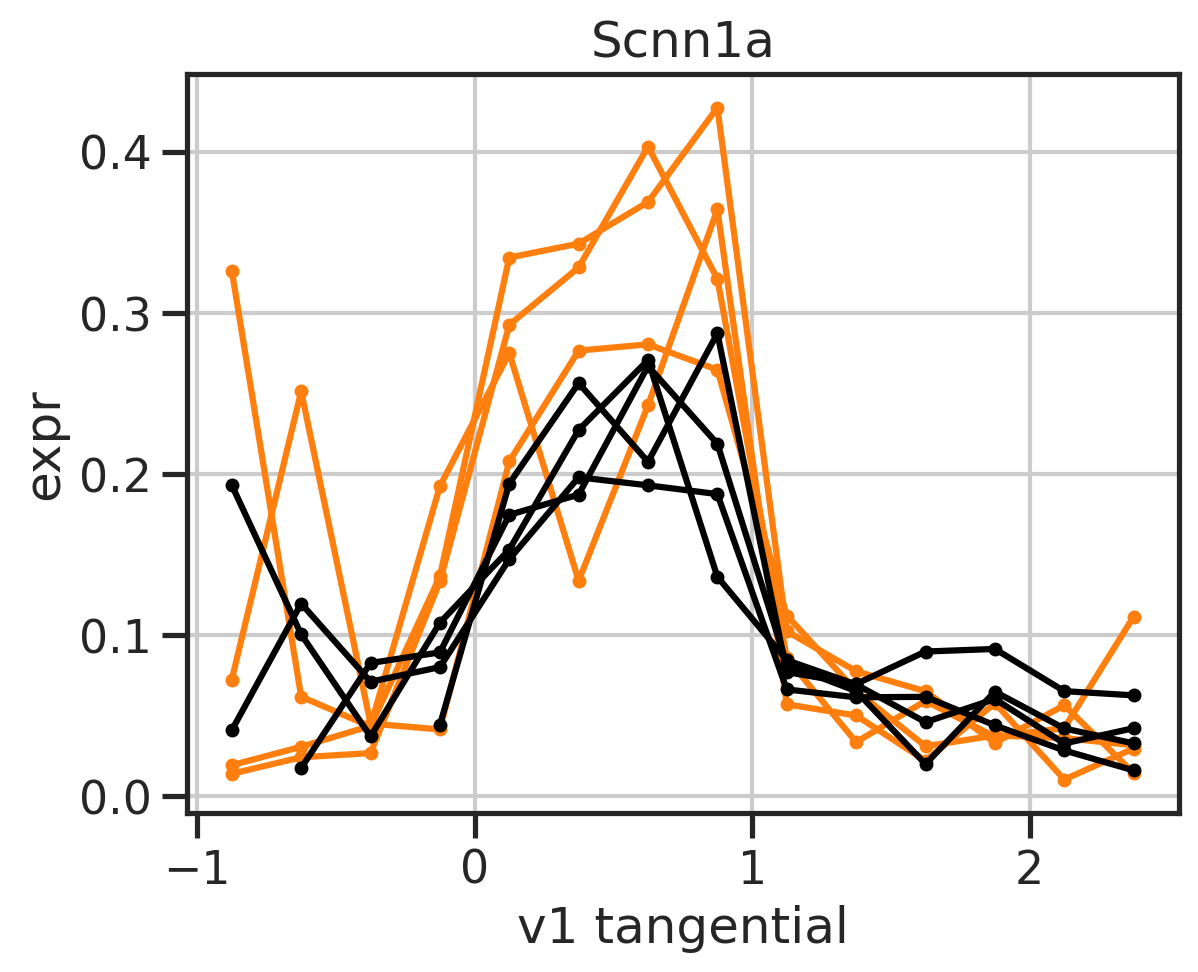

In [24]:
gn = 'Scnn1a'
for name, color in zip(names, colors):
    adatasub = adata[adata.obs['sample']==name]
    cond = np.logical_and(adatasub.obs['depth']<600, adatasub.obs['depth']>300)
    adatasub = adatasub[cond]
    
    lnorm_mean, lnorm_sem, lnorm_std, n, _, _ = binning_pipe2(adatasub, 'width_norm', 'ljnorm', bins=bins)
    plt.plot(midbins, lnorm_mean[gn], '-o', color=color, markersize=4)
    plt.title(gn)
    plt.xlabel('v1 tangential')
    plt.ylabel('expr')
plt.show()

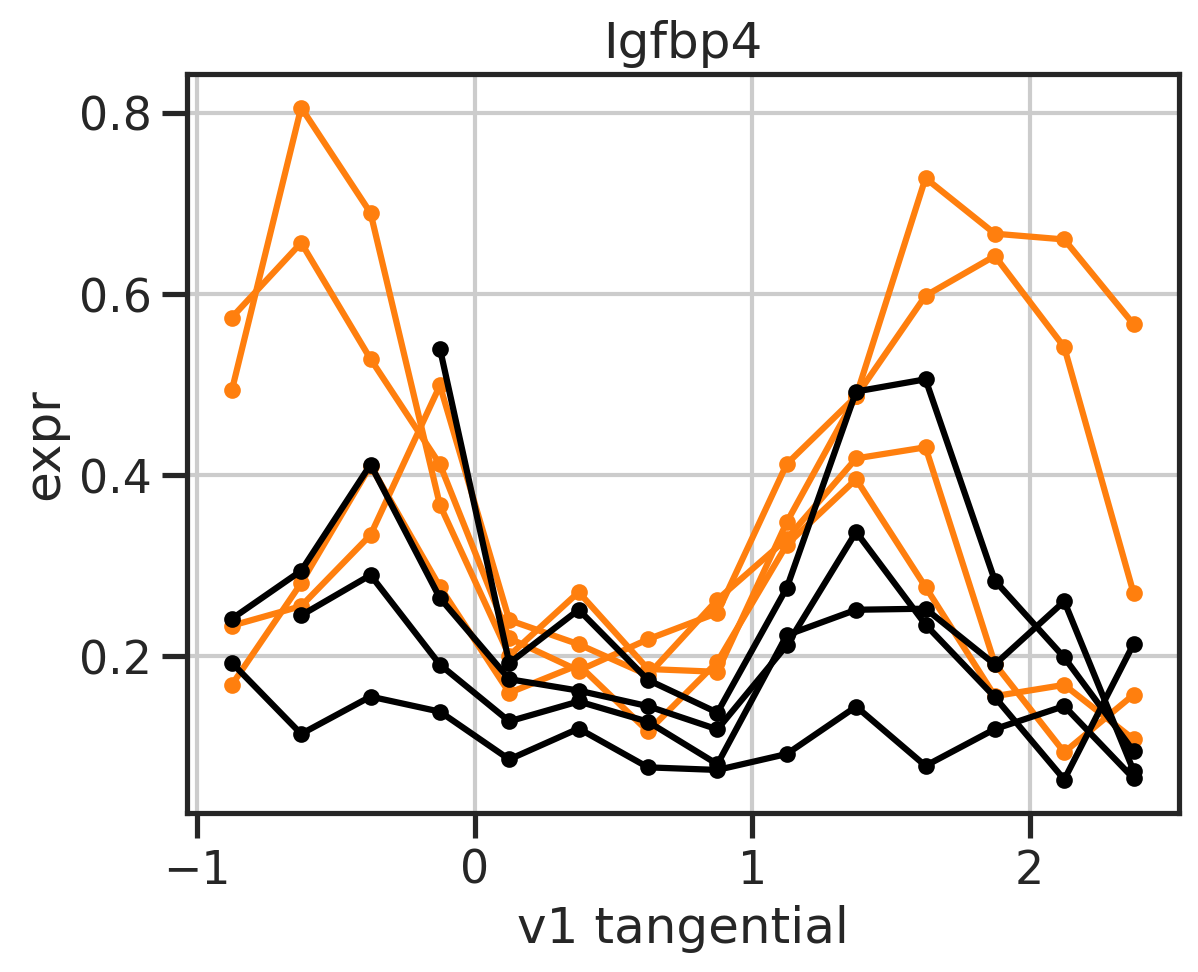

In [25]:
gn = 'Igfbp4'
for name, color in zip(names, colors):
    adatasub = adata[adata.obs['sample']==name]
    cond = np.logical_and(adatasub.obs['depth']<400, adatasub.obs['depth']>100)
    adatasub = adatasub[cond]
    
    lnorm_mean, lnorm_sem, lnorm_std, n, _, _ = binning_pipe2(adatasub, 'width_norm', 'ljnorm', bins=bins)
    plt.plot(midbins, lnorm_mean[gn], '-o', color=color, markersize=5)
    plt.title(gn)
    plt.xlabel('v1 tangential')
    plt.ylabel('expr')
plt.show()

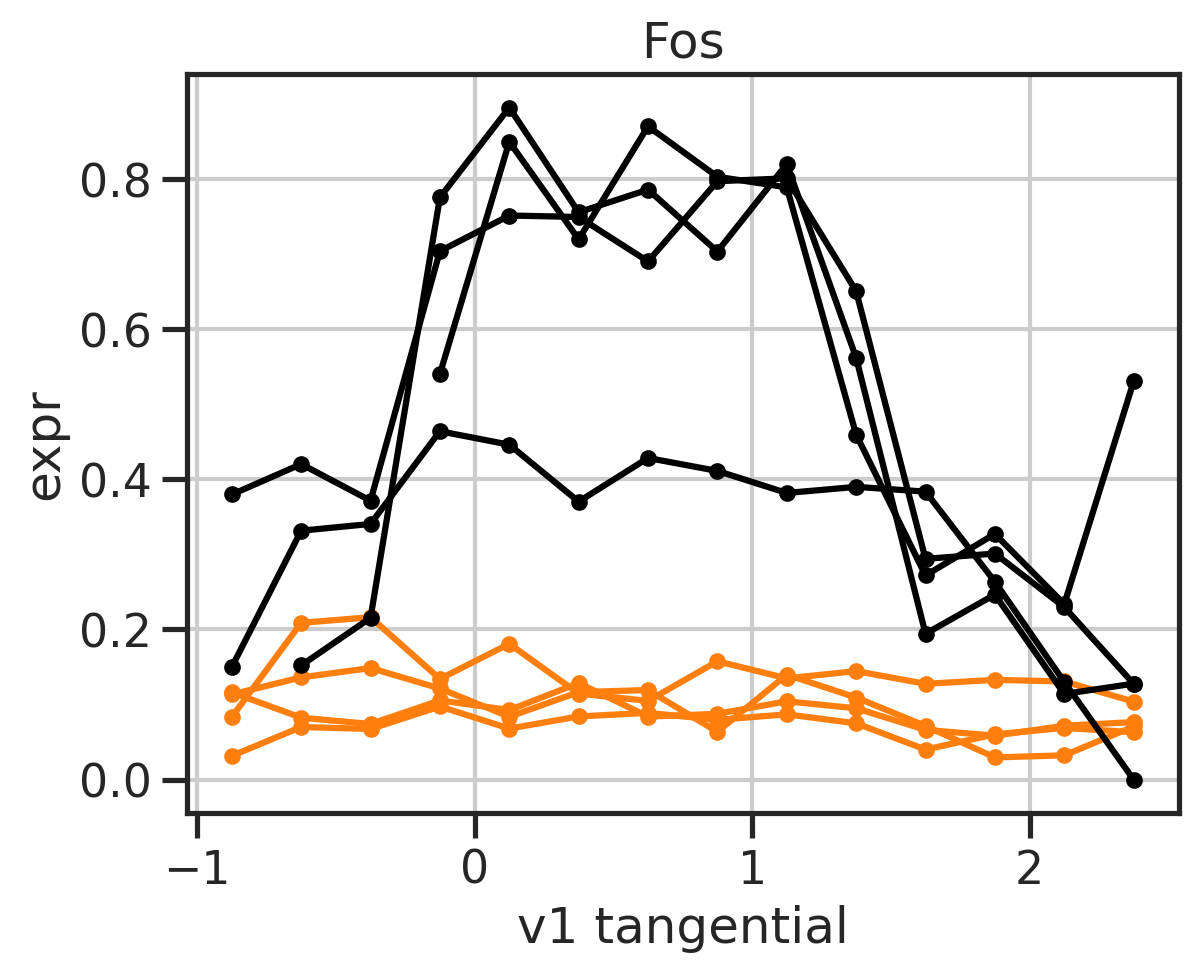

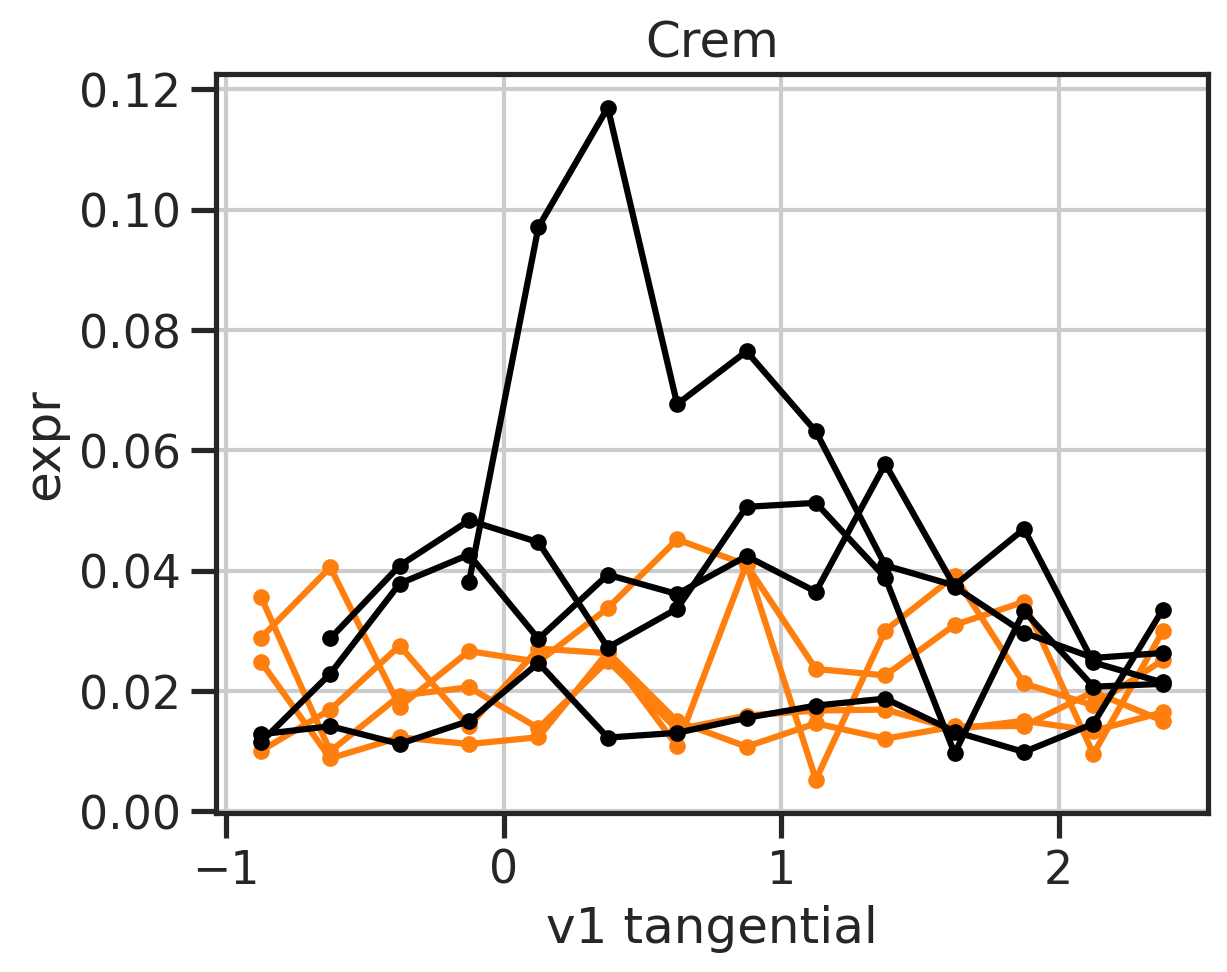

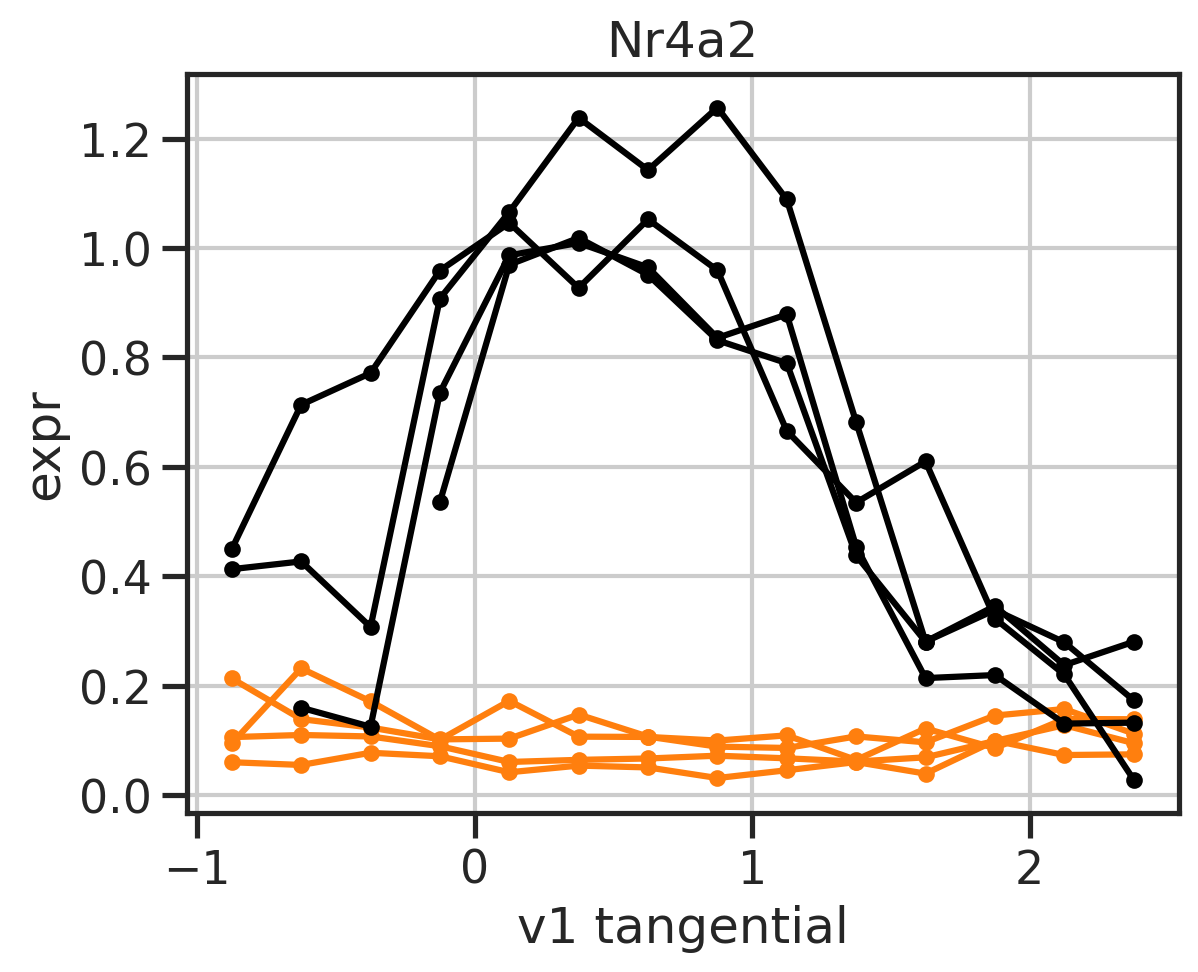

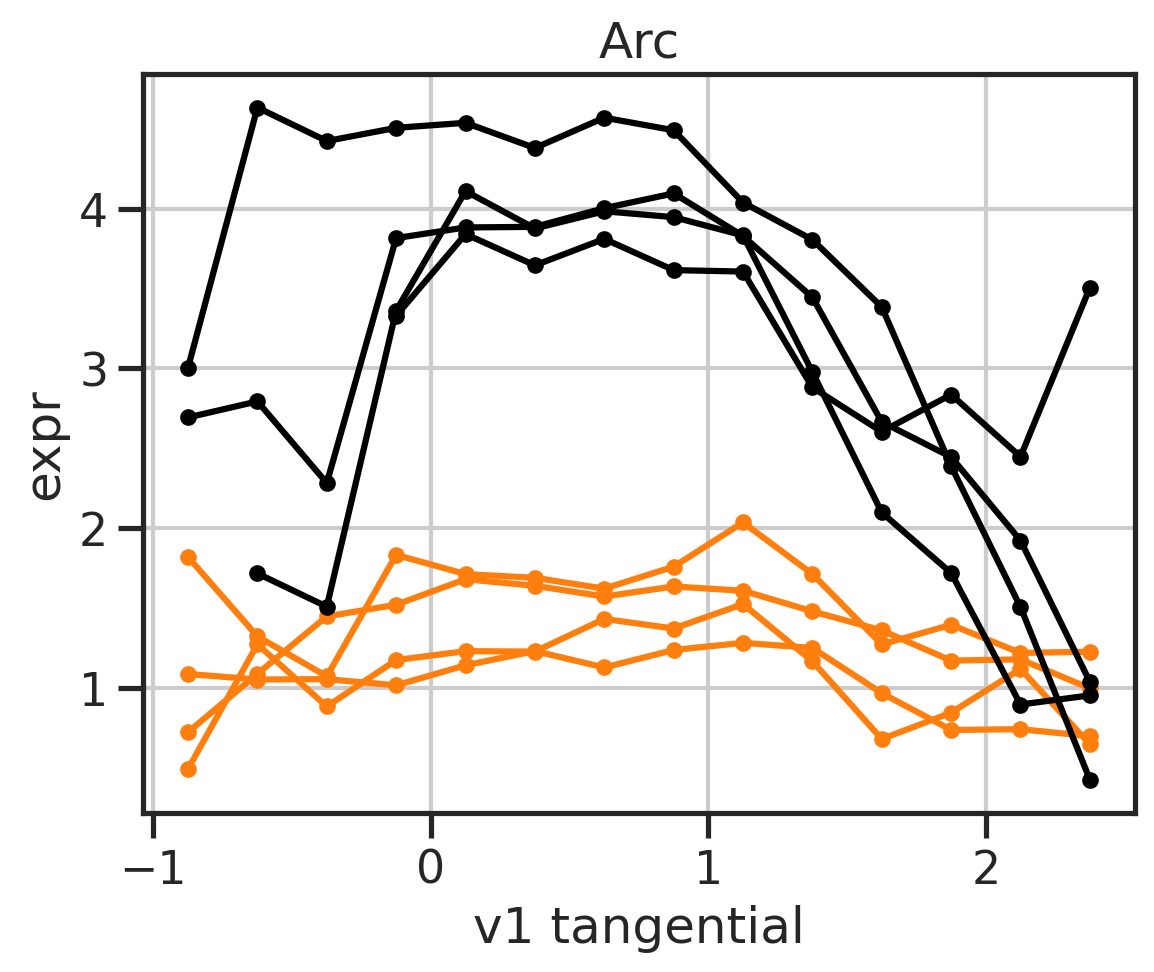

In [26]:
for gn in ['Fos', 'Crem', 'Nr4a2', 'Arc']: #, 'Cdh13', 'Sorcs3', 'Chrm2']:
    for name, color in zip(names, colors):
        adatasub = adata[adata.obs['sample']==name]
        adatasub = adatasub[adatasub.obs['depth']<400]
        
        lnorm_mean, lnorm_sem, lnorm_std, n, _, _ = binning_pipe2(adatasub, 'width_norm',  'ljnorm', bins=bins)
        plt.plot(midbins, lnorm_mean[gn], '-o', color=color, markersize=5)
        plt.title(gn)
        plt.xlabel('v1 tangential')
        plt.ylabel('expr')
    plt.show()

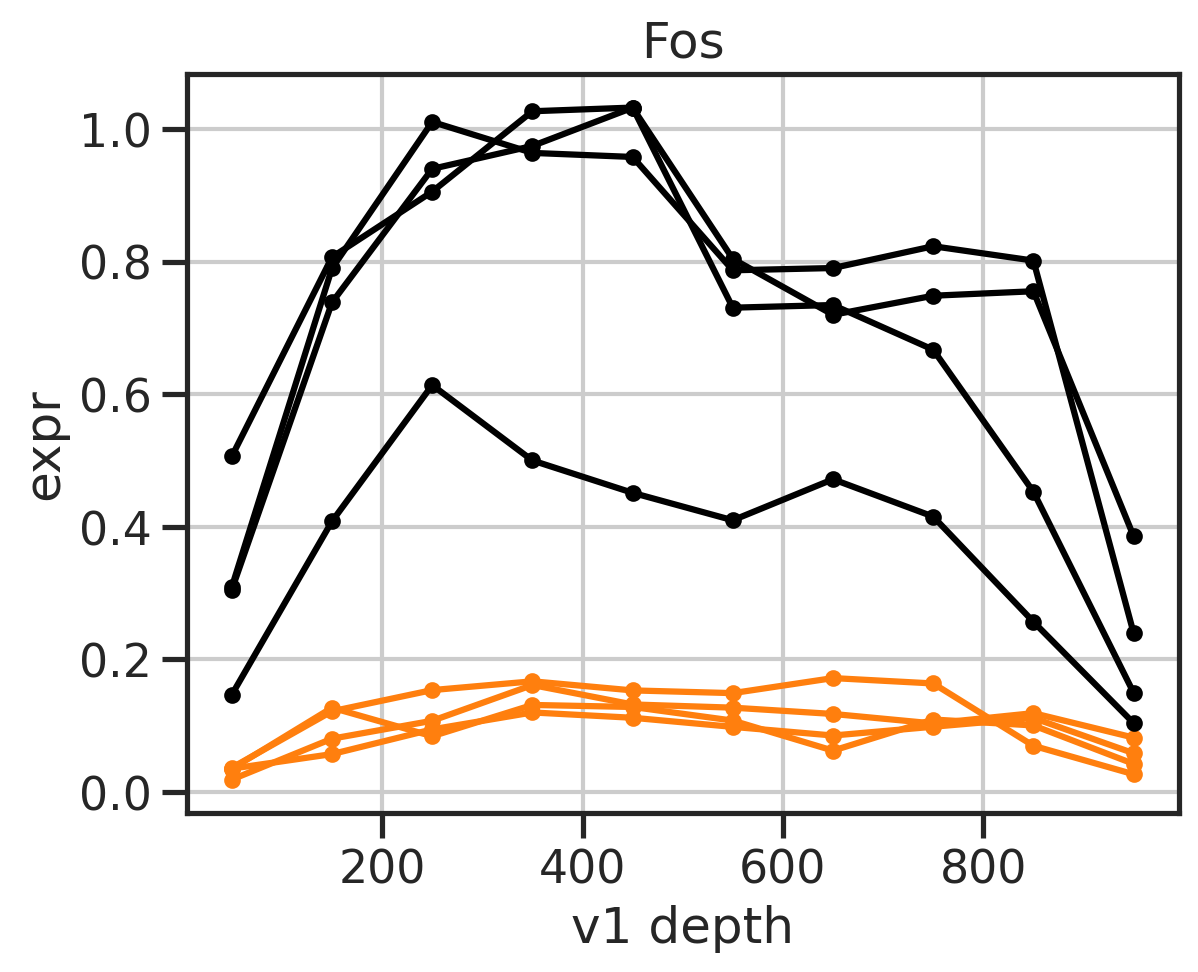

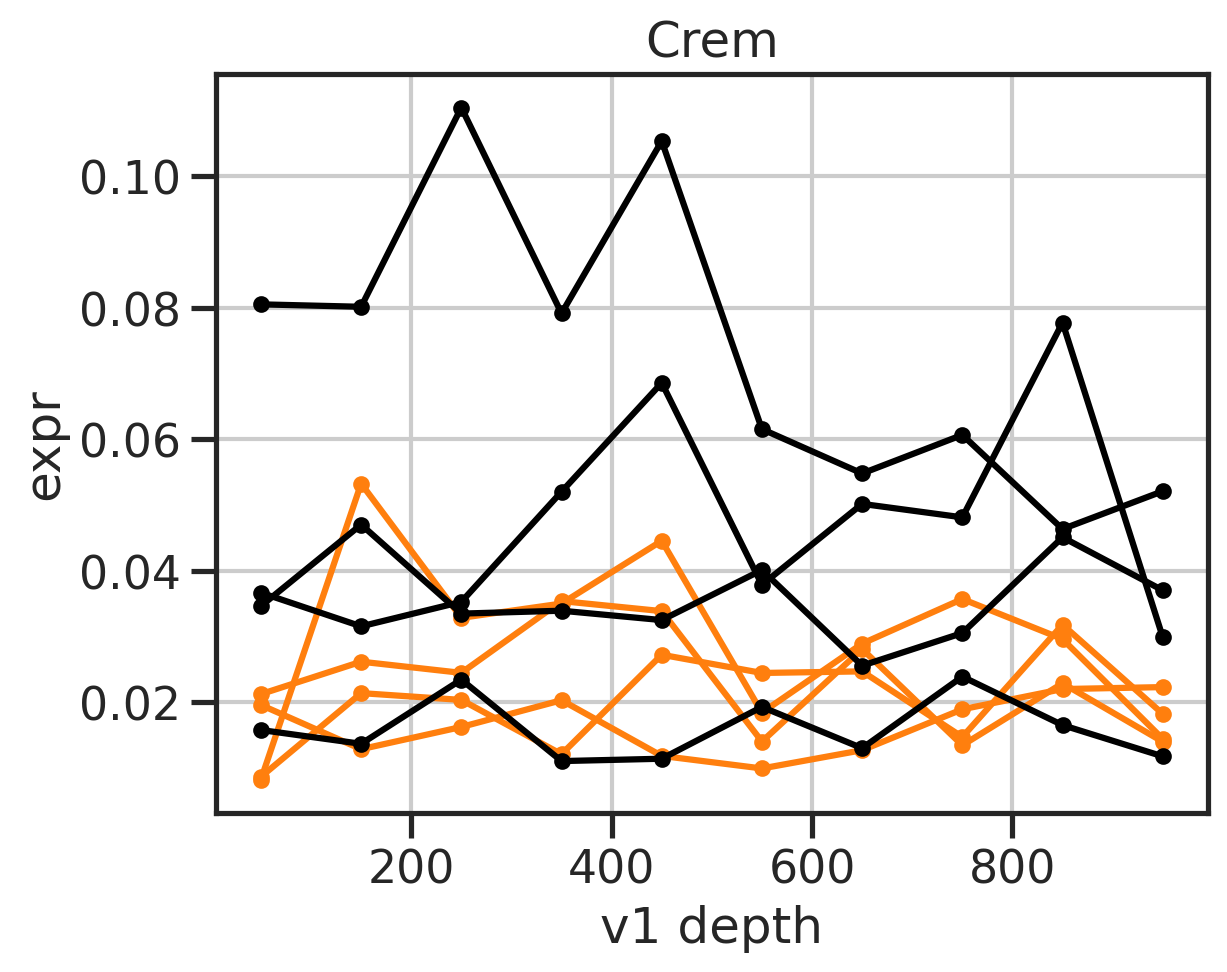

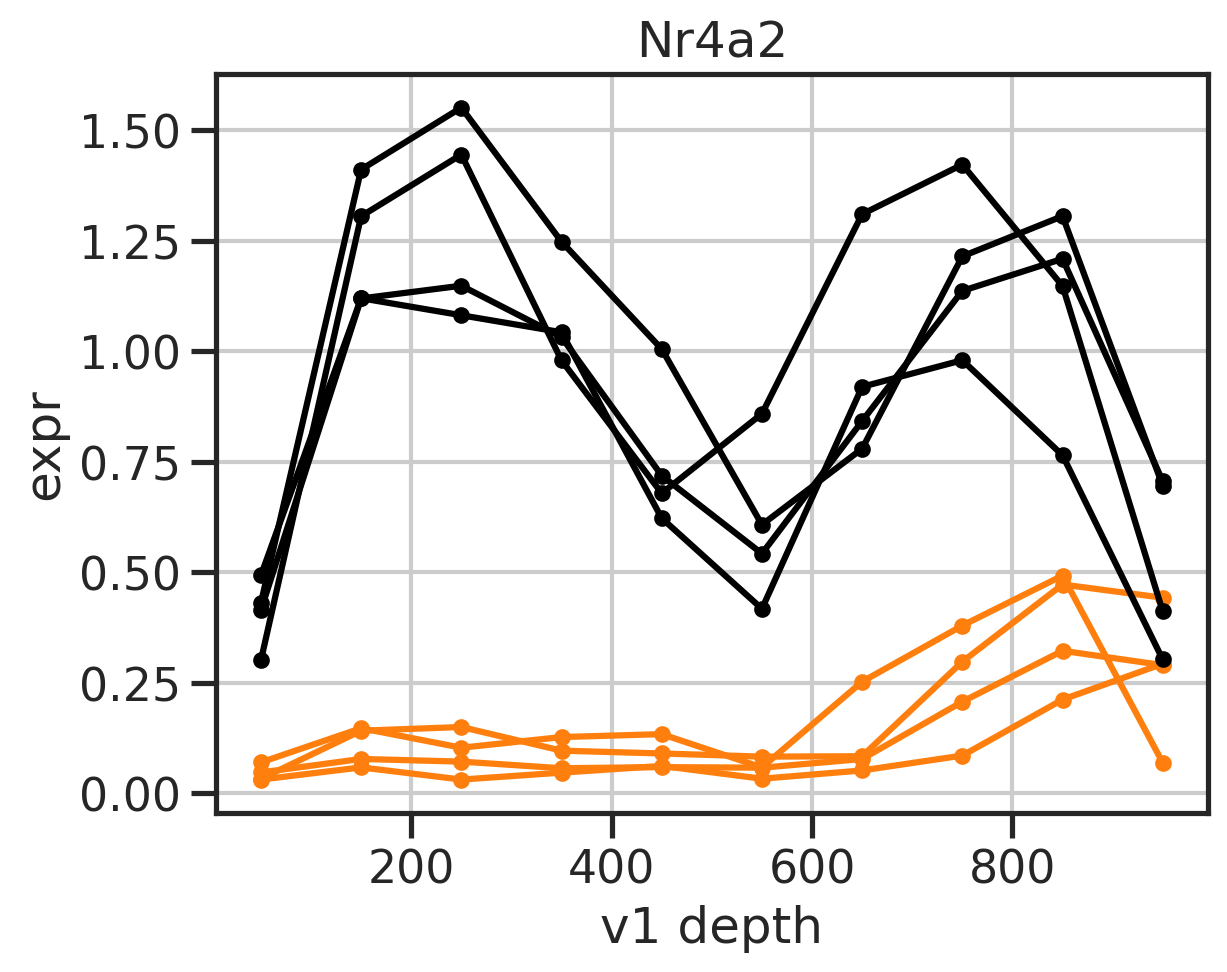

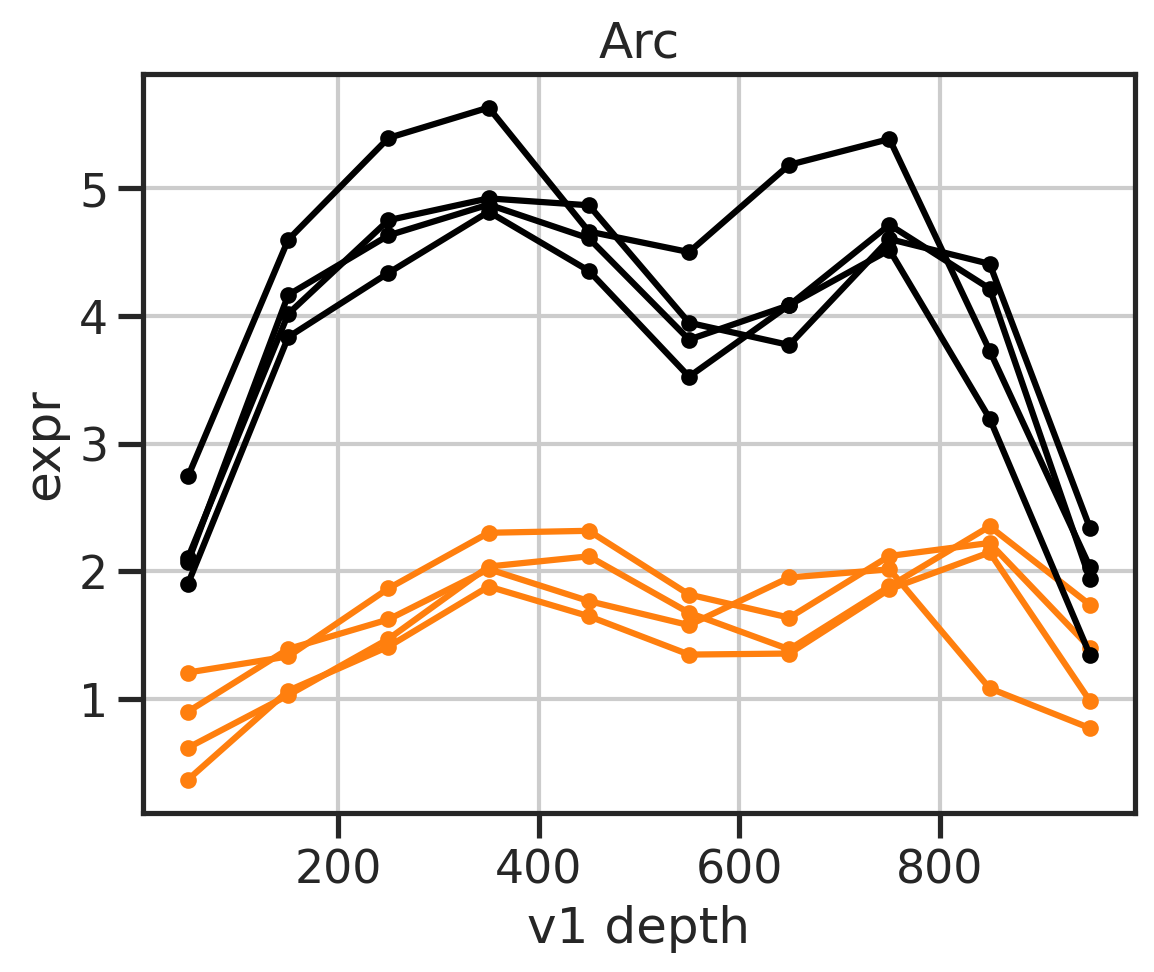

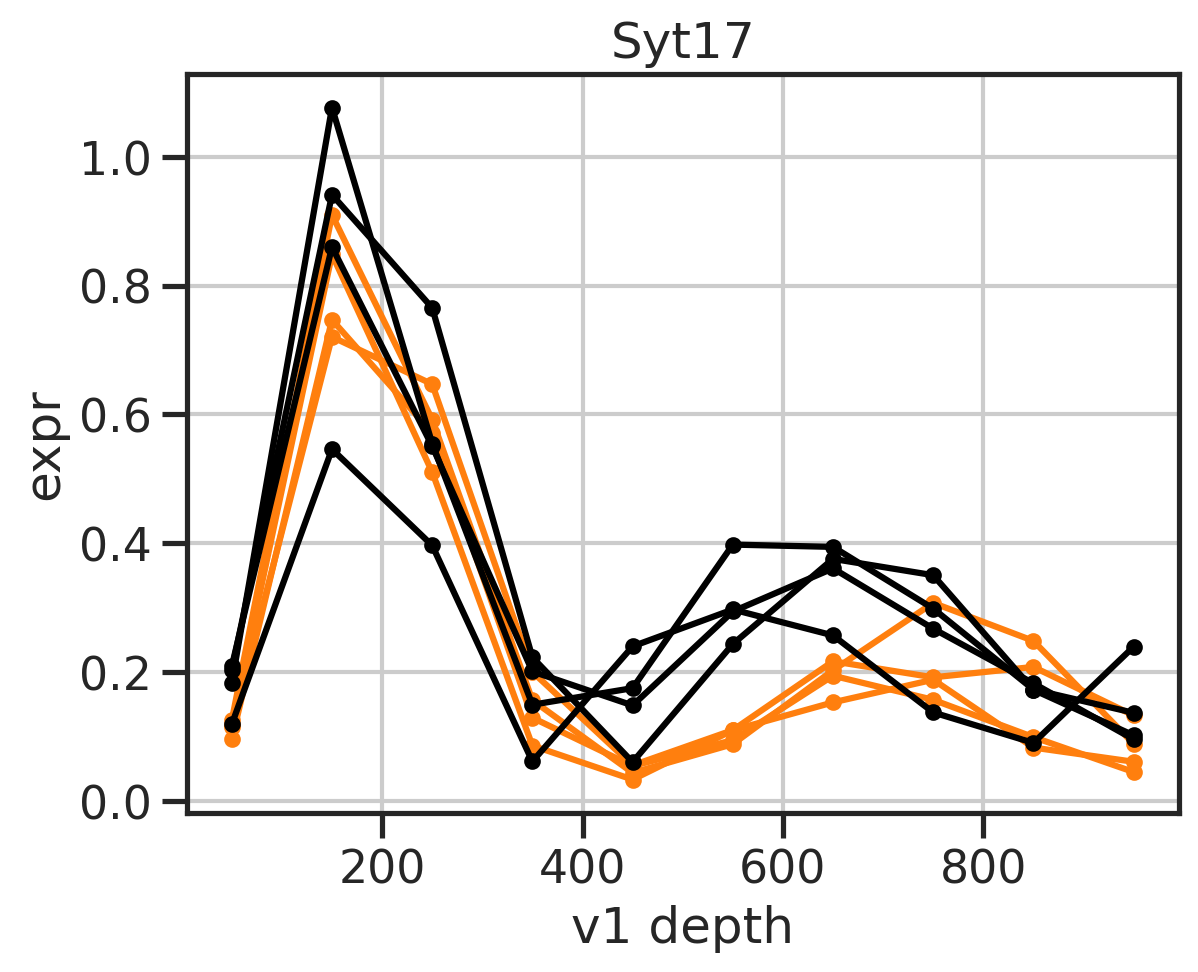

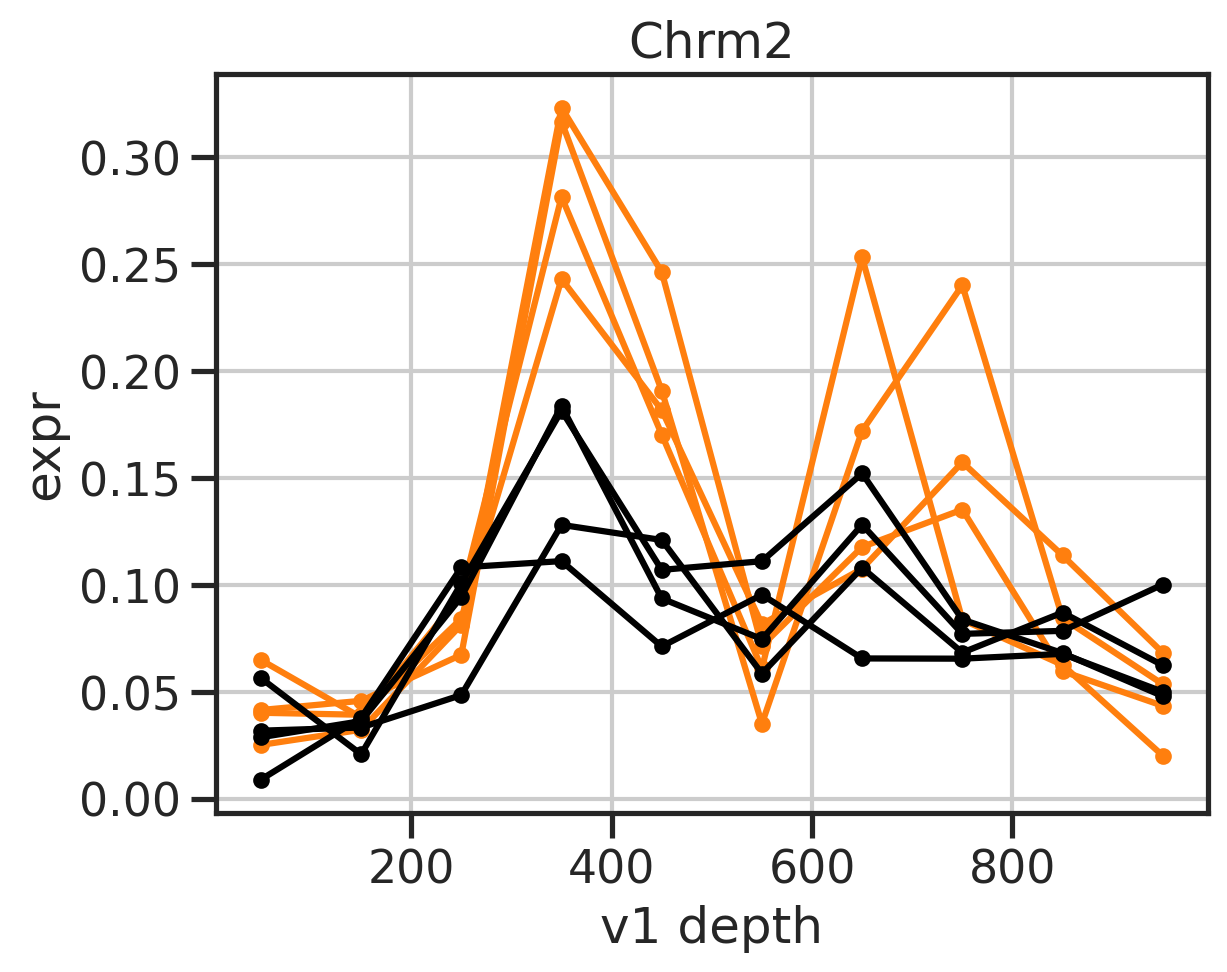

In [27]:
colors = ['C1']*4+['k']*4

for gn in ['Fos', 'Crem', 'Nr4a2', 'Arc', 'Syt17', 'Chrm2']: #, 'Cdh13', 'Sorcs3', 'Chrm2']:
    for name, color in zip(names, colors):
        adatasub = adata[adata.obs['sample']==name]
        adatasub = adatasub[adatasub.obs['width_norm']<1]
        adatasub = adatasub[adatasub.obs['width_norm']>0]
        
        lnorm_mean, lnorm_sem, lnorm_std, n, _, _ = binning_pipe2(adatasub, 'depth',  'ljnorm', bins=bins_depth)
        plt.plot(midbins_depth, lnorm_mean[gn], '-o', color=color, markersize=5)
        plt.title(gn)
        plt.xlabel('v1 depth')
        plt.ylabel('expr')
    plt.show()

In [28]:
def mean_pipe(adata, names, col, bins, col_limit, limit_min, limit_max):
    """
    """
    lnorm_mean_all = []
    for name in names:
        adatasub = adata[adata.obs['sample']==name]
        cond = np.logical_and(adatasub.obs[col_limit]>limit_min, 
                              adatasub.obs[col_limit]<limit_max)
        adatasub = adatasub[cond]

        lnorm_mean, _, _, _, _, _ = binning_pipe2(adatasub, col, 'ljnorm', bins=bins)
        lnorm_mean_all.append(lnorm_mean)
    lnorm_mean_all = np.array(lnorm_mean_all)
    
    numpb_nr = (~np.isnan(lnorm_mean_all[:4,:,0])).sum(axis=0)
    numpb_dr = (~np.isnan(lnorm_mean_all[4:,:,0])).sum(axis=0)
    mean_nr = np.nanmean(lnorm_mean_all[:4], axis=0)
    mean_dr = np.nanmean(lnorm_mean_all[4:], axis=0)
    sem_nr = np.nanstd(lnorm_mean_all[:4], axis=0)/np.sqrt(numpb_nr.reshape(-1,1))
    sem_dr = np.nanstd(lnorm_mean_all[4:], axis=0)/np.sqrt(numpb_dr.reshape(-1,1))
    
    
    print(numpb_nr, numpb_dr)
    
    return lnorm_mean_all, mean_nr, mean_dr, sem_nr, sem_dr


In [29]:
def mean_l2fc_over_gene_groups(mean_samples, names):
    """
    """
    # mean is set at NR V1 mean
    base_a0 = []
    base_b0 = []
    base_c0 = []
    base_i0 = []
    print(names[:4])
    for i, name in enumerate(names[:4]):
        mean = mean_samples[i]
        base_a = np.nanmean(mean[:,agenes_idx], axis=0) # across bins for each gene
        base_b = np.nanmean(mean[:,bgenes_idx], axis=0) # across bins for each gene
        base_c = np.nanmean(mean[:,cgenes_idx], axis=0) # across bins for each gene
        base_i = np.nanmean(mean[:,igenes_idx], axis=0) # across bins for each gene

        base_a0.append(base_a)
        base_b0.append(base_b)
        base_c0.append(base_c)
        base_i0.append(base_i)

    base_a0 = np.nanmean(base_a0, axis=0)
    base_b0 = np.nanmean(base_b0, axis=0)
    base_c0 = np.nanmean(base_c0, axis=0)
    base_i0 = np.nanmean(base_i0, axis=0)

    print(base_a0.shape, base_b0.shape, base_c0.shape, base_i0.shape)

    # mean log2 fold changes over many genes
    samp_bin_gene_mat = []
    for i, name in enumerate(names):
        mean = mean_samples[i]
        amean = np.nanmean(mean[:,agenes_idx]-base_a0, axis=1) # a bin vector
        bmean = np.nanmean(mean[:,bgenes_idx]-base_b0, axis=1) # a bin vector
        cmean = np.nanmean(mean[:,cgenes_idx]-base_c0, axis=1) # a bin vector
        imean = np.nanmean(mean[:,igenes_idx]-base_i0, axis=1) # a bin vector
        samp_bin_gene_mat.append(np.vstack([amean, bmean, cmean, imean]).T)
    samp_bin_gene_mat = np.array(samp_bin_gene_mat)
    numpb_nr = (~np.isnan(samp_bin_gene_mat[:4,:,0])).sum(axis=0)
    numpb_dr = (~np.isnan(samp_bin_gene_mat[4:,:,0])).sum(axis=0)

    nr_mat = samp_bin_gene_mat[:4]
    nr_mfc = np.nanmean(nr_mat, axis=0) #  bin, gene group
    nr_sem = np.nanstd(nr_mat, axis=0)/np.sqrt(numpb_nr.reshape(-1,1)) 

    dr_mat = samp_bin_gene_mat[4:]
    dr_mfc = np.nanmean(dr_mat, axis=0) 
    dr_sem = np.nanstd(dr_mat, axis=0)/np.sqrt(numpb_dr.reshape(-1,1)) 

    print(samp_bin_gene_mat.shape) # sample, bin, gene group, 
    print(nr_mfc.shape, dr_mfc.shape)

    print(numpb_nr, numpb_dr)
    return nr_mfc, nr_sem, dr_mfc, dr_sem

In [30]:
def plot_hist_ax(ax, midbins, mean_nr, sem_nr, mean_dr, sem_dr, gidx, gn=''):
    """
    """
    valm = mean_nr[:,gidx].reshape(-1,)
    vale = sem_nr[:,gidx].reshape(-1,)
    ax.plot(midbins, valm, '-o', markersize=5, color='C1')
    ax.fill_between(midbins, valm-vale, valm+vale, color='C1', alpha=0.1, edgecolor='none')

    valm = mean_dr[:,gidx].reshape(-1,)
    vale = sem_dr[:,gidx].reshape(-1,)
    ax.plot(midbins, valm, '-o', markersize=5, color='k')
    ax.fill_between(midbins, valm-vale, valm+vale,color='k', alpha=0.1, edgecolor='none')
    sns.despine(ax=ax)
    ax.grid(False)
    ax.set_ylabel('Gene expr')
    ax.set_title(gn)
    
    return ax 
    

In [31]:
mean_samples_l4, mean_nr_l4, mean_dr_l4, sem_nr_l4, sem_dr_l4      = mean_pipe(adata, names, 'width_norm', bins, 'depth', 300, 600)
mean_samples_l23, mean_nr_l23, mean_dr_l23, sem_nr_l23, sem_dr_l23 = mean_pipe(adata, names, 'width_norm', bins, 'depth', 100, 400)
mean_samples_dp, mean_nr_dp, mean_dr_dp, sem_nr_dp, sem_dr_dp      = mean_pipe(adata, names, 'depth', bins_depth, 'width_norm', 0, 1)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4] [2 3 3 4 4 4 4 4 4 4 4 4 4 4]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4] [2 3 3 4 4 4 4 4 4 4 4 4 4 4]
[4 4 4 4 4 4 4 4 4 4] [4 4 4 4 4 4 4 4 4 4]


In [32]:
nr_mfc, nr_sem, dr_mfc, dr_sem             = mean_l2fc_over_gene_groups(mean_samples_l23, names)
nr_mfc_dp, nr_sem_dp, dr_mfc_dp, dr_sem_dp = mean_l2fc_over_gene_groups(mean_samples_dp, names)

['P28NRa_ant', 'P28NRa_pos', 'P28NRb_ant', 'P28NRb_pos']
(64,) (35,) (71,) (16,)
(8, 14, 4)
(14, 4) (14, 4)
[4 4 4 4 4 4 4 4 4 4 4 4 4 4] [2 3 3 4 4 4 4 4 4 4 4 4 4 4]
['P28NRa_ant', 'P28NRa_pos', 'P28NRb_ant', 'P28NRb_pos']
(64,) (35,) (71,) (16,)
(8, 10, 4)
(10, 4) (10, 4)
[4 4 4 4 4 4 4 4 4 4] [4 4 4 4 4 4 4 4 4 4]


/tmp/ipykernel_776/560549591.py:33: RuntimeWarning: Mean of empty slice
  amean = np.nanmean(mean[:,agenes_idx]-base_a0, axis=1) # a bin vector
/tmp/ipykernel_776/560549591.py:34: RuntimeWarning: Mean of empty slice
  bmean = np.nanmean(mean[:,bgenes_idx]-base_b0, axis=1) # a bin vector
/tmp/ipykernel_776/560549591.py:35: RuntimeWarning: Mean of empty slice
  cmean = np.nanmean(mean[:,cgenes_idx]-base_c0, axis=1) # a bin vector
/tmp/ipykernel_776/560549591.py:36: RuntimeWarning: Mean of empty slice
  imean = np.nanmean(mean[:,igenes_idx]-base_i0, axis=1) # a bin vector


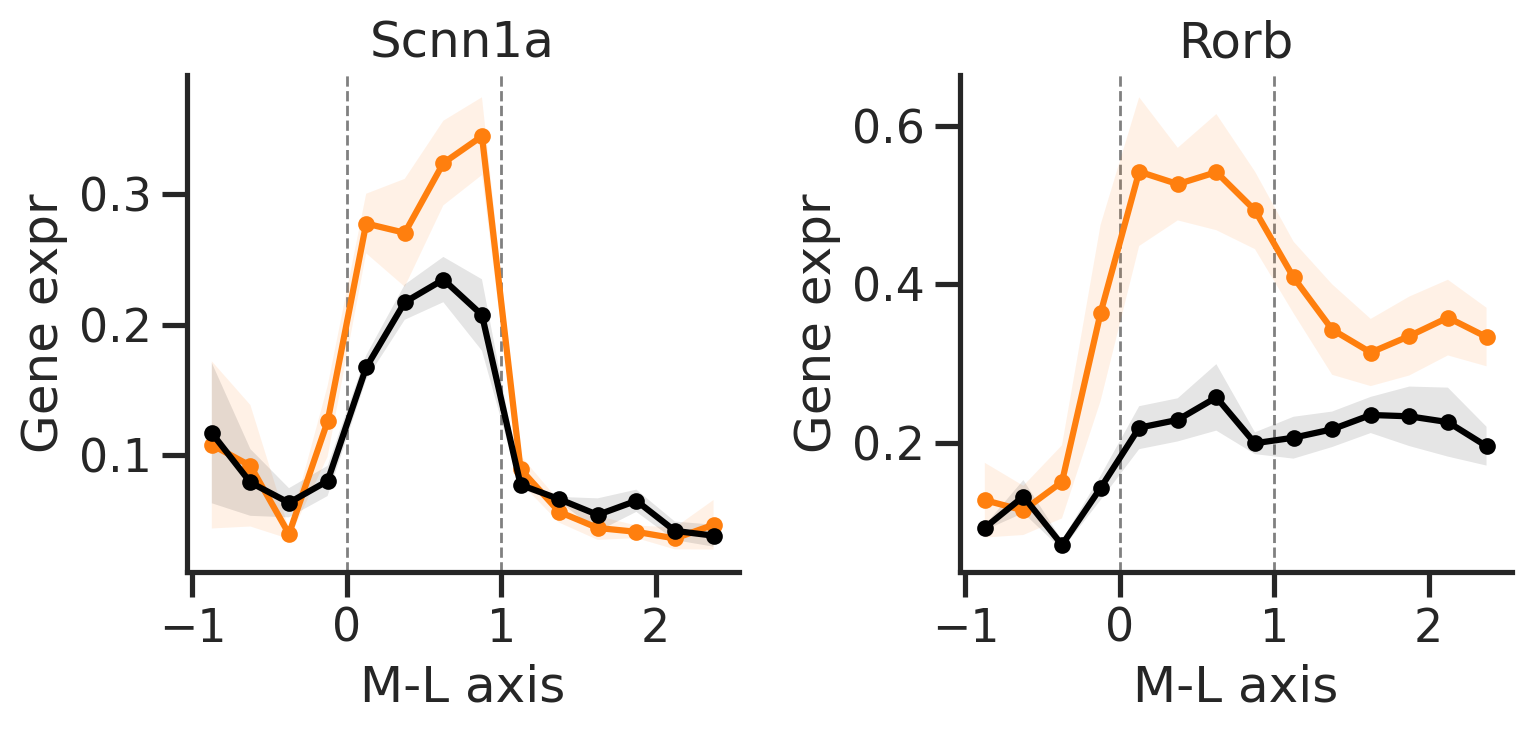

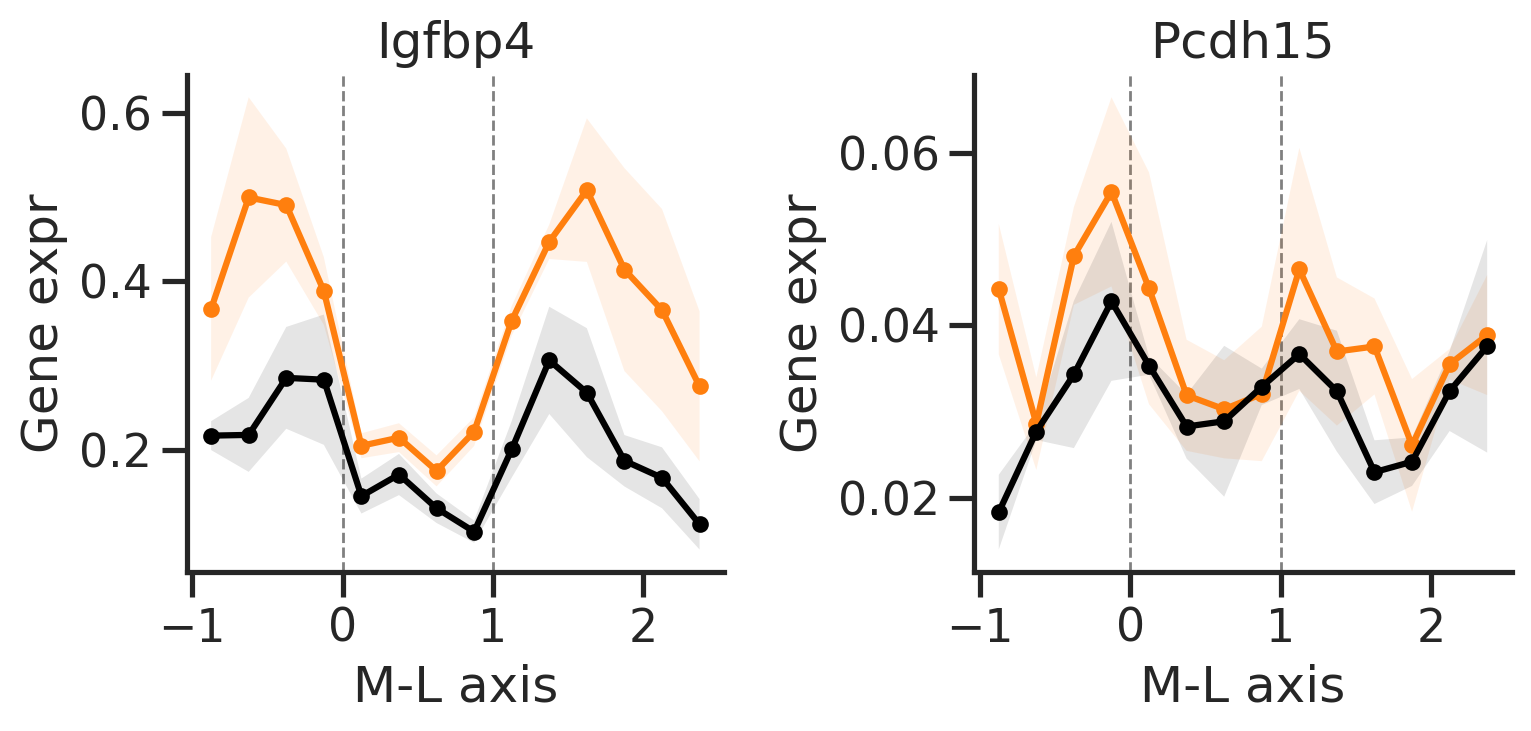

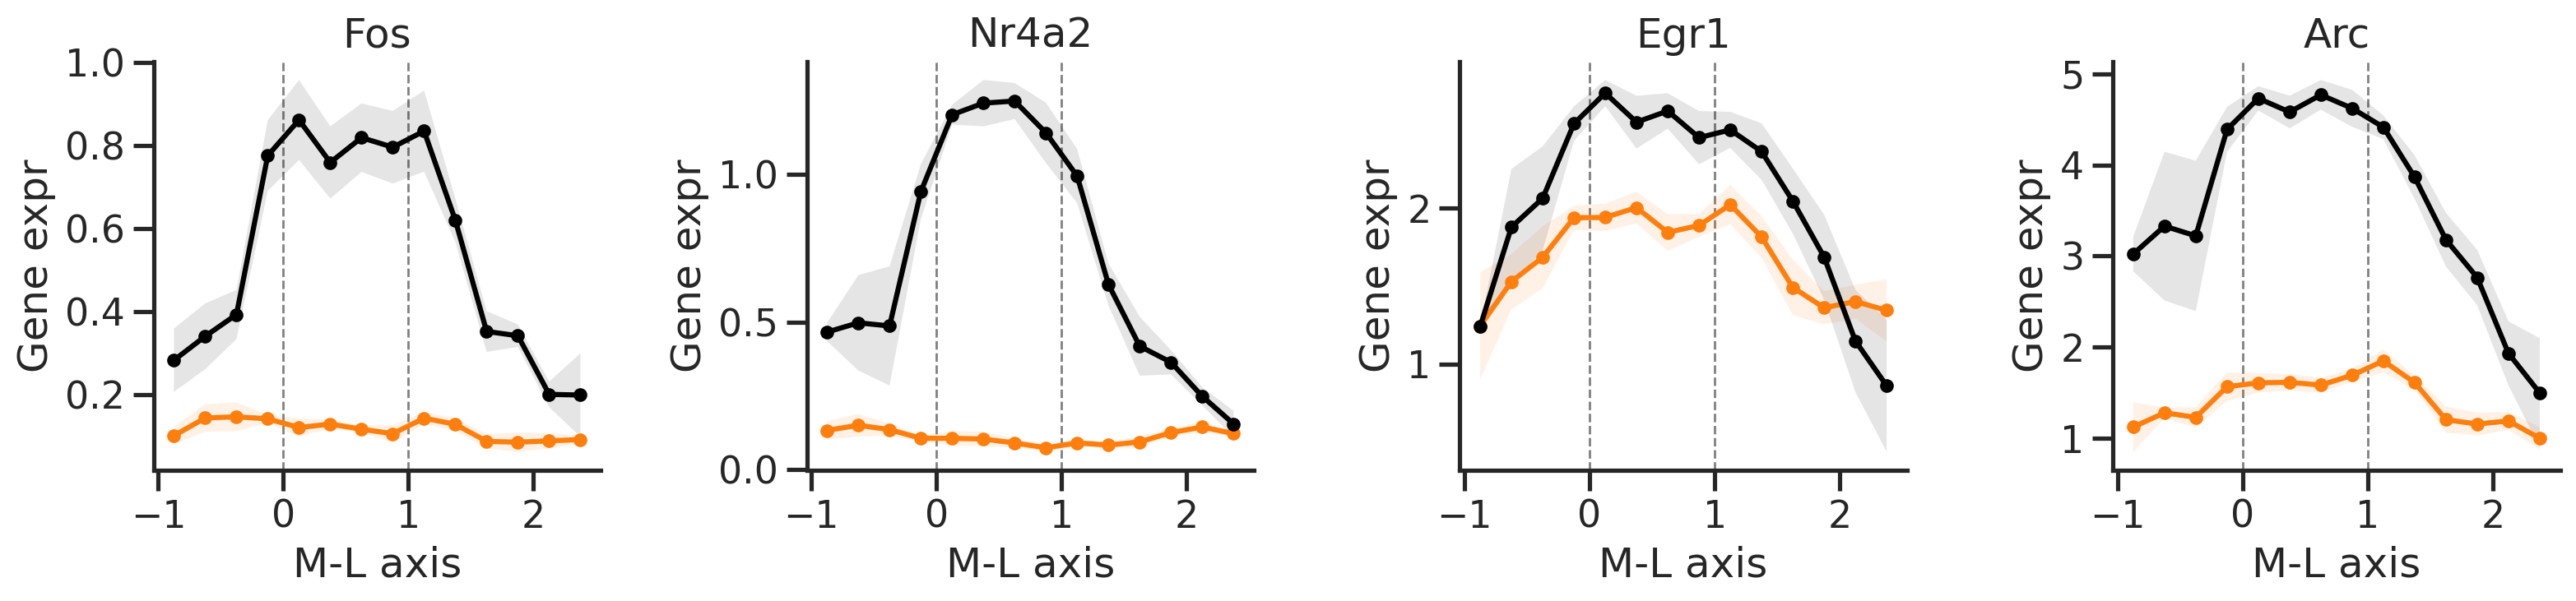

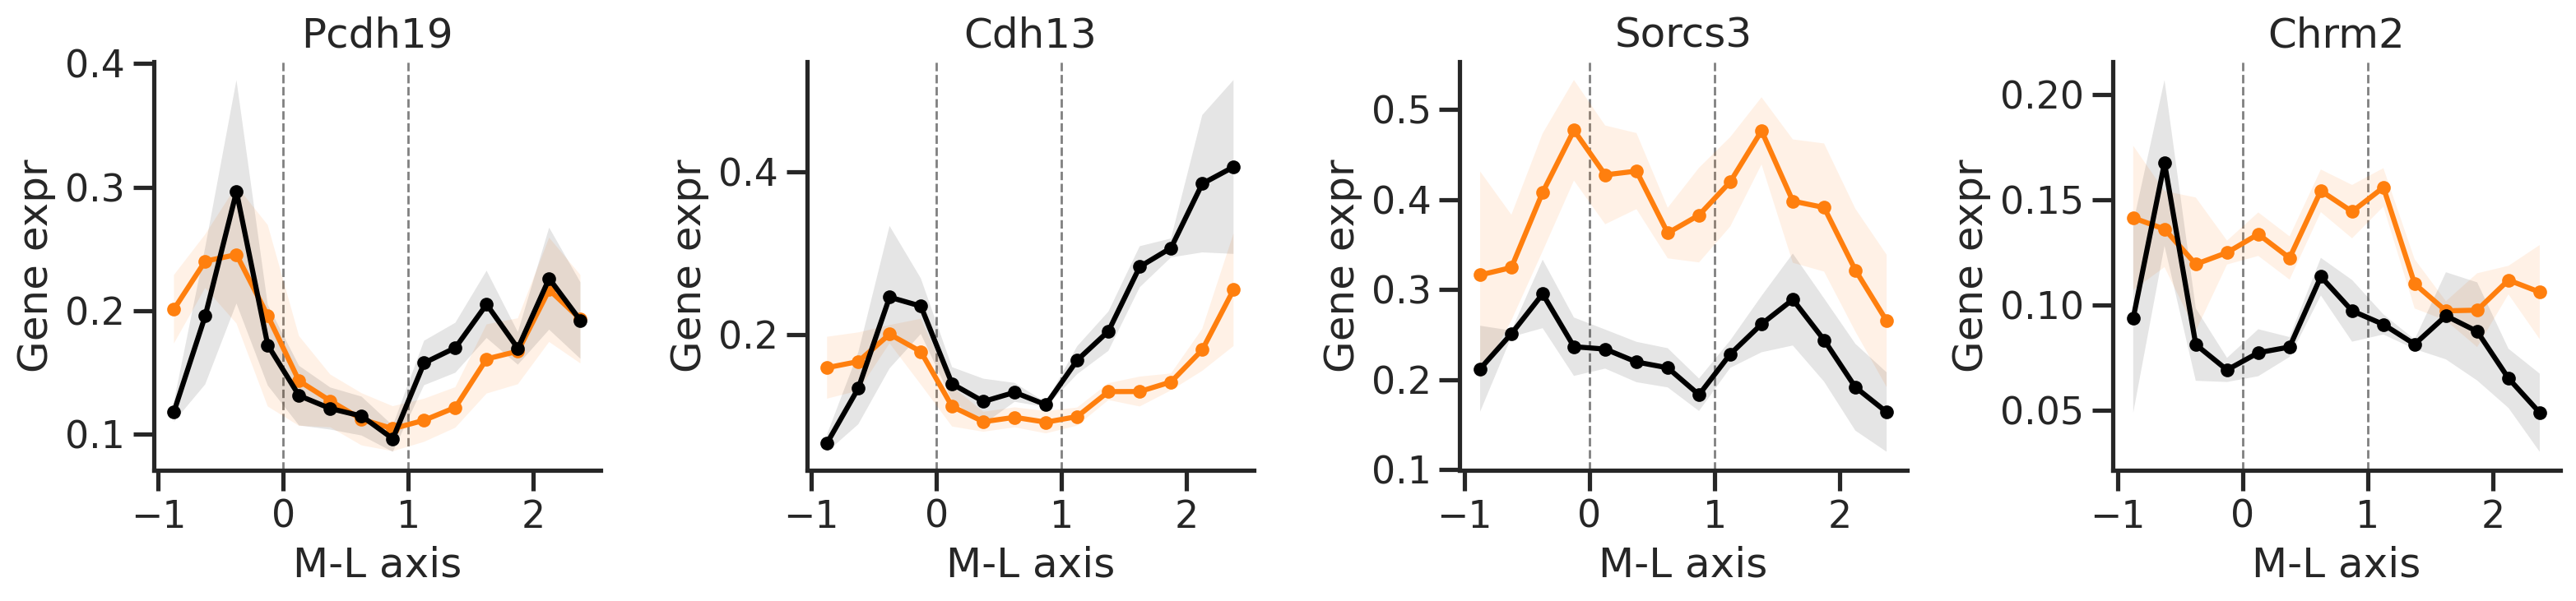

In [33]:
gns = ['Scnn1a', 'Rorb']
n = len(gns)
fig, axs = plt.subplots(1,n,figsize=(n*4,4))
for i, gn in enumerate(gns):
    gidx = basicu.get_index_from_array(adata.var.index.values, [gn])
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins, mean_nr_l4, sem_nr_l4, mean_dr_l4, sem_dr_l4, gidx, gn)
    ax.set_xticks([-1,0,1,2])
    ax.axvline(0, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.axvline(1, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('M-L axis')
fig.tight_layout()
plt.show()


gns = ['Igfbp4', 'Pcdh15',
      ]
n = len(gns)
fig, axs = plt.subplots(1,n,figsize=(n*4,4))
for i, gn in enumerate(gns):
    gidx = basicu.get_index_from_array(adata.var.index.values, [gn])
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins, mean_nr_l23, sem_nr_l23, mean_dr_l23, sem_dr_l23, gidx, gn)
    ax.set_xticks([-1,0,1,2])
    ax.axvline(0, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.axvline(1, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('M-L axis')
fig.tight_layout()
plt.show()

gns = [ 
       'Fos', 'Nr4a2', 'Egr1', 'Arc',   
      ]
n = len(gns)
fig, axs = plt.subplots(1,n,figsize=(n*4,4))
for i, gn in enumerate(gns):
    gidx = basicu.get_index_from_array(adata.var.index.values, [gn])
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins, mean_nr_l23, sem_nr_l23, mean_dr_l23, sem_dr_l23, gidx, gn)
    ax.set_xticks([-1,0,1,2])
    ax.axvline(0, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.axvline(1, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('M-L axis')
fig.tight_layout()
plt.show()

gns = ['Pcdh19', 'Cdh13', 'Sorcs3', 'Chrm2',
        ]
n = len(gns)
fig, axs = plt.subplots(1,n,figsize=(n*4,4))
for i, gn in enumerate(gns):
    gidx = basicu.get_index_from_array(adata.var.index.values, [gn])
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins, mean_nr_l23, sem_nr_l23, mean_dr_l23, sem_dr_l23, gidx, gn)
    ax.set_xticks([-1,0,1,2])
    ax.axvline(0, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.axvline(1, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('M-L axis')
fig.tight_layout()
plt.show()

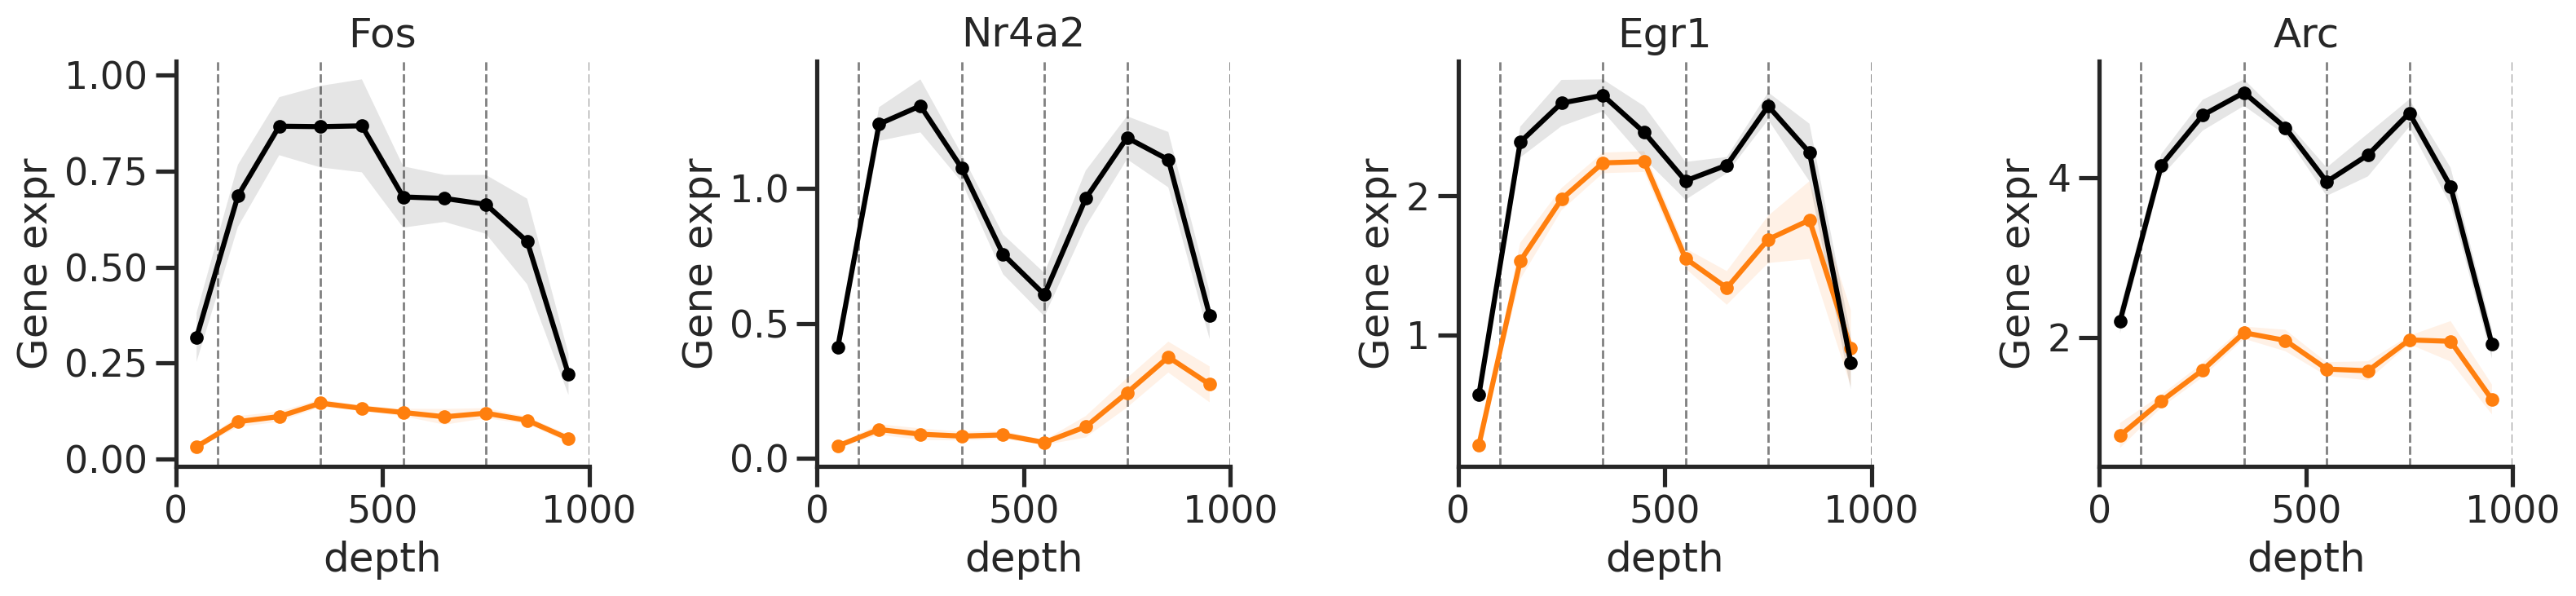

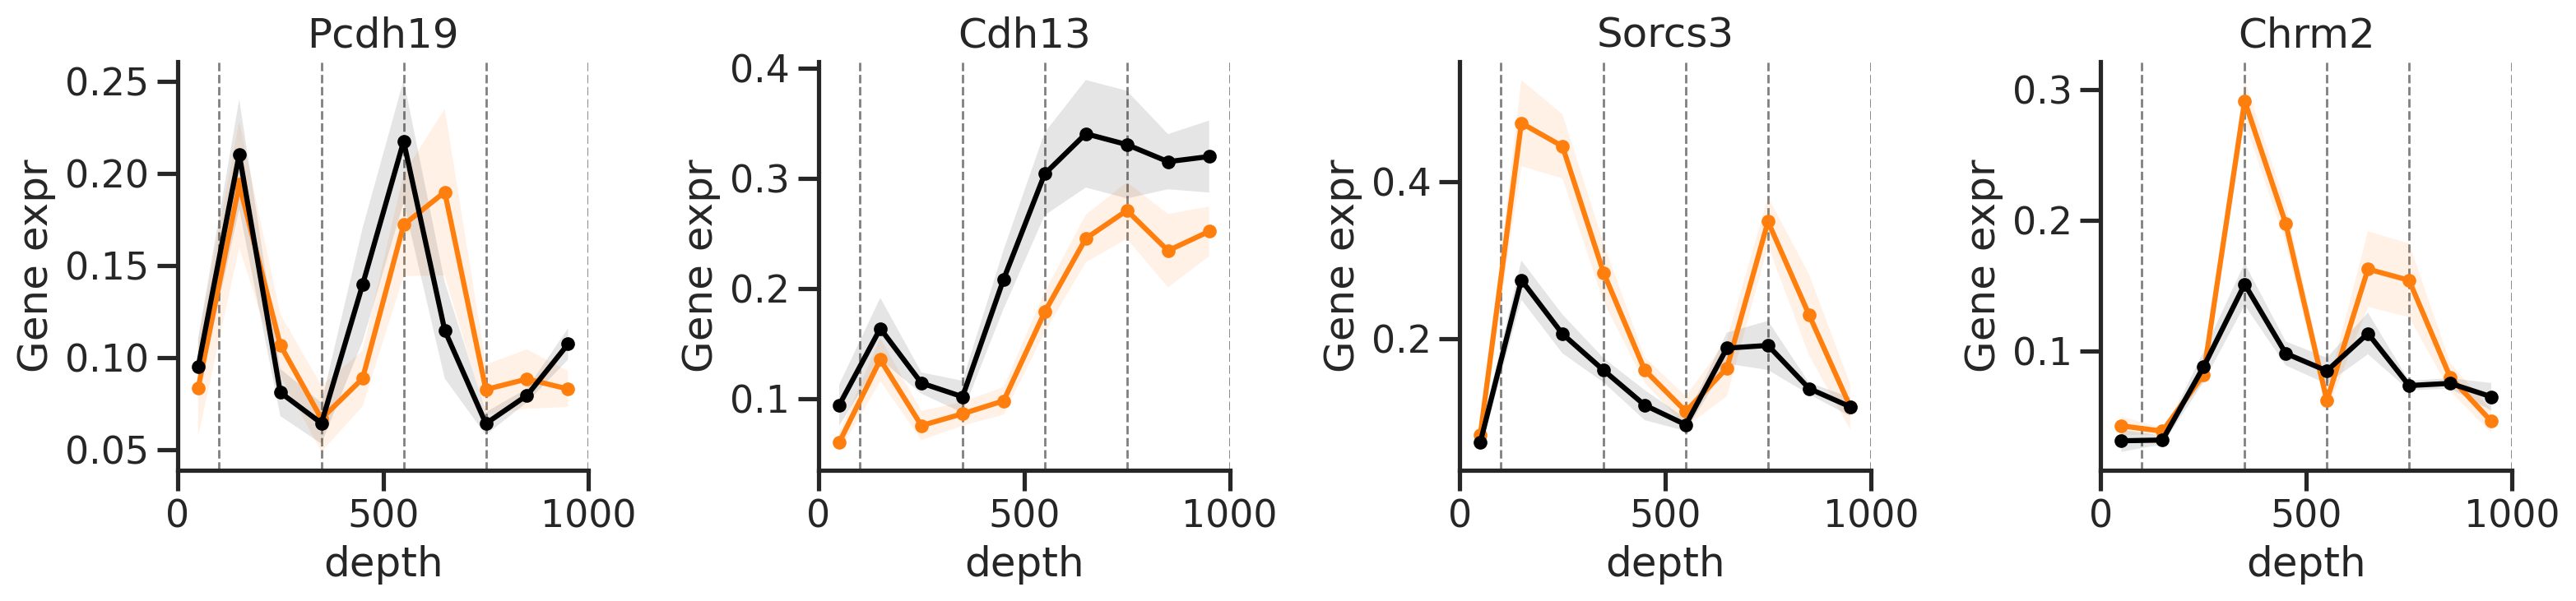

In [34]:
gns = [ 
       'Fos', 'Nr4a2', 'Egr1', 'Arc',   
      ]
n = len(gns)
fig, axs = plt.subplots(1,n,figsize=(n*4,4))
for i, gn in enumerate(gns):
    gidx = basicu.get_index_from_array(adata.var.index.values, [gn])
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins_depth, mean_nr_dp, sem_nr_dp, mean_dr_dp, sem_dr_dp, gidx, gn)
    ax.set_xticks(np.arange(0,1000+1,500))
    for d in [100,350,550,750,1000]:
        ax.axvline(d, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('depth')
fig.tight_layout()
plt.show()

gns = [ 
    'Pcdh19', 'Cdh13', 'Sorcs3', 'Chrm2'
      ]
n = len(gns)
fig, axs = plt.subplots(1,n,figsize=(n*4,4))
for i, gn in enumerate(gns):
    gidx = basicu.get_index_from_array(adata.var.index.values, [gn])
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins_depth, mean_nr_dp, sem_nr_dp, mean_dr_dp, sem_dr_dp, gidx, gn)
    ax.set_xticks(np.arange(0,1000+1,500))
    for d in [100,350,550,750,1000]:
        ax.axvline(d, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('depth')
fig.tight_layout()
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/2_2024-09-10.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/2.pdf


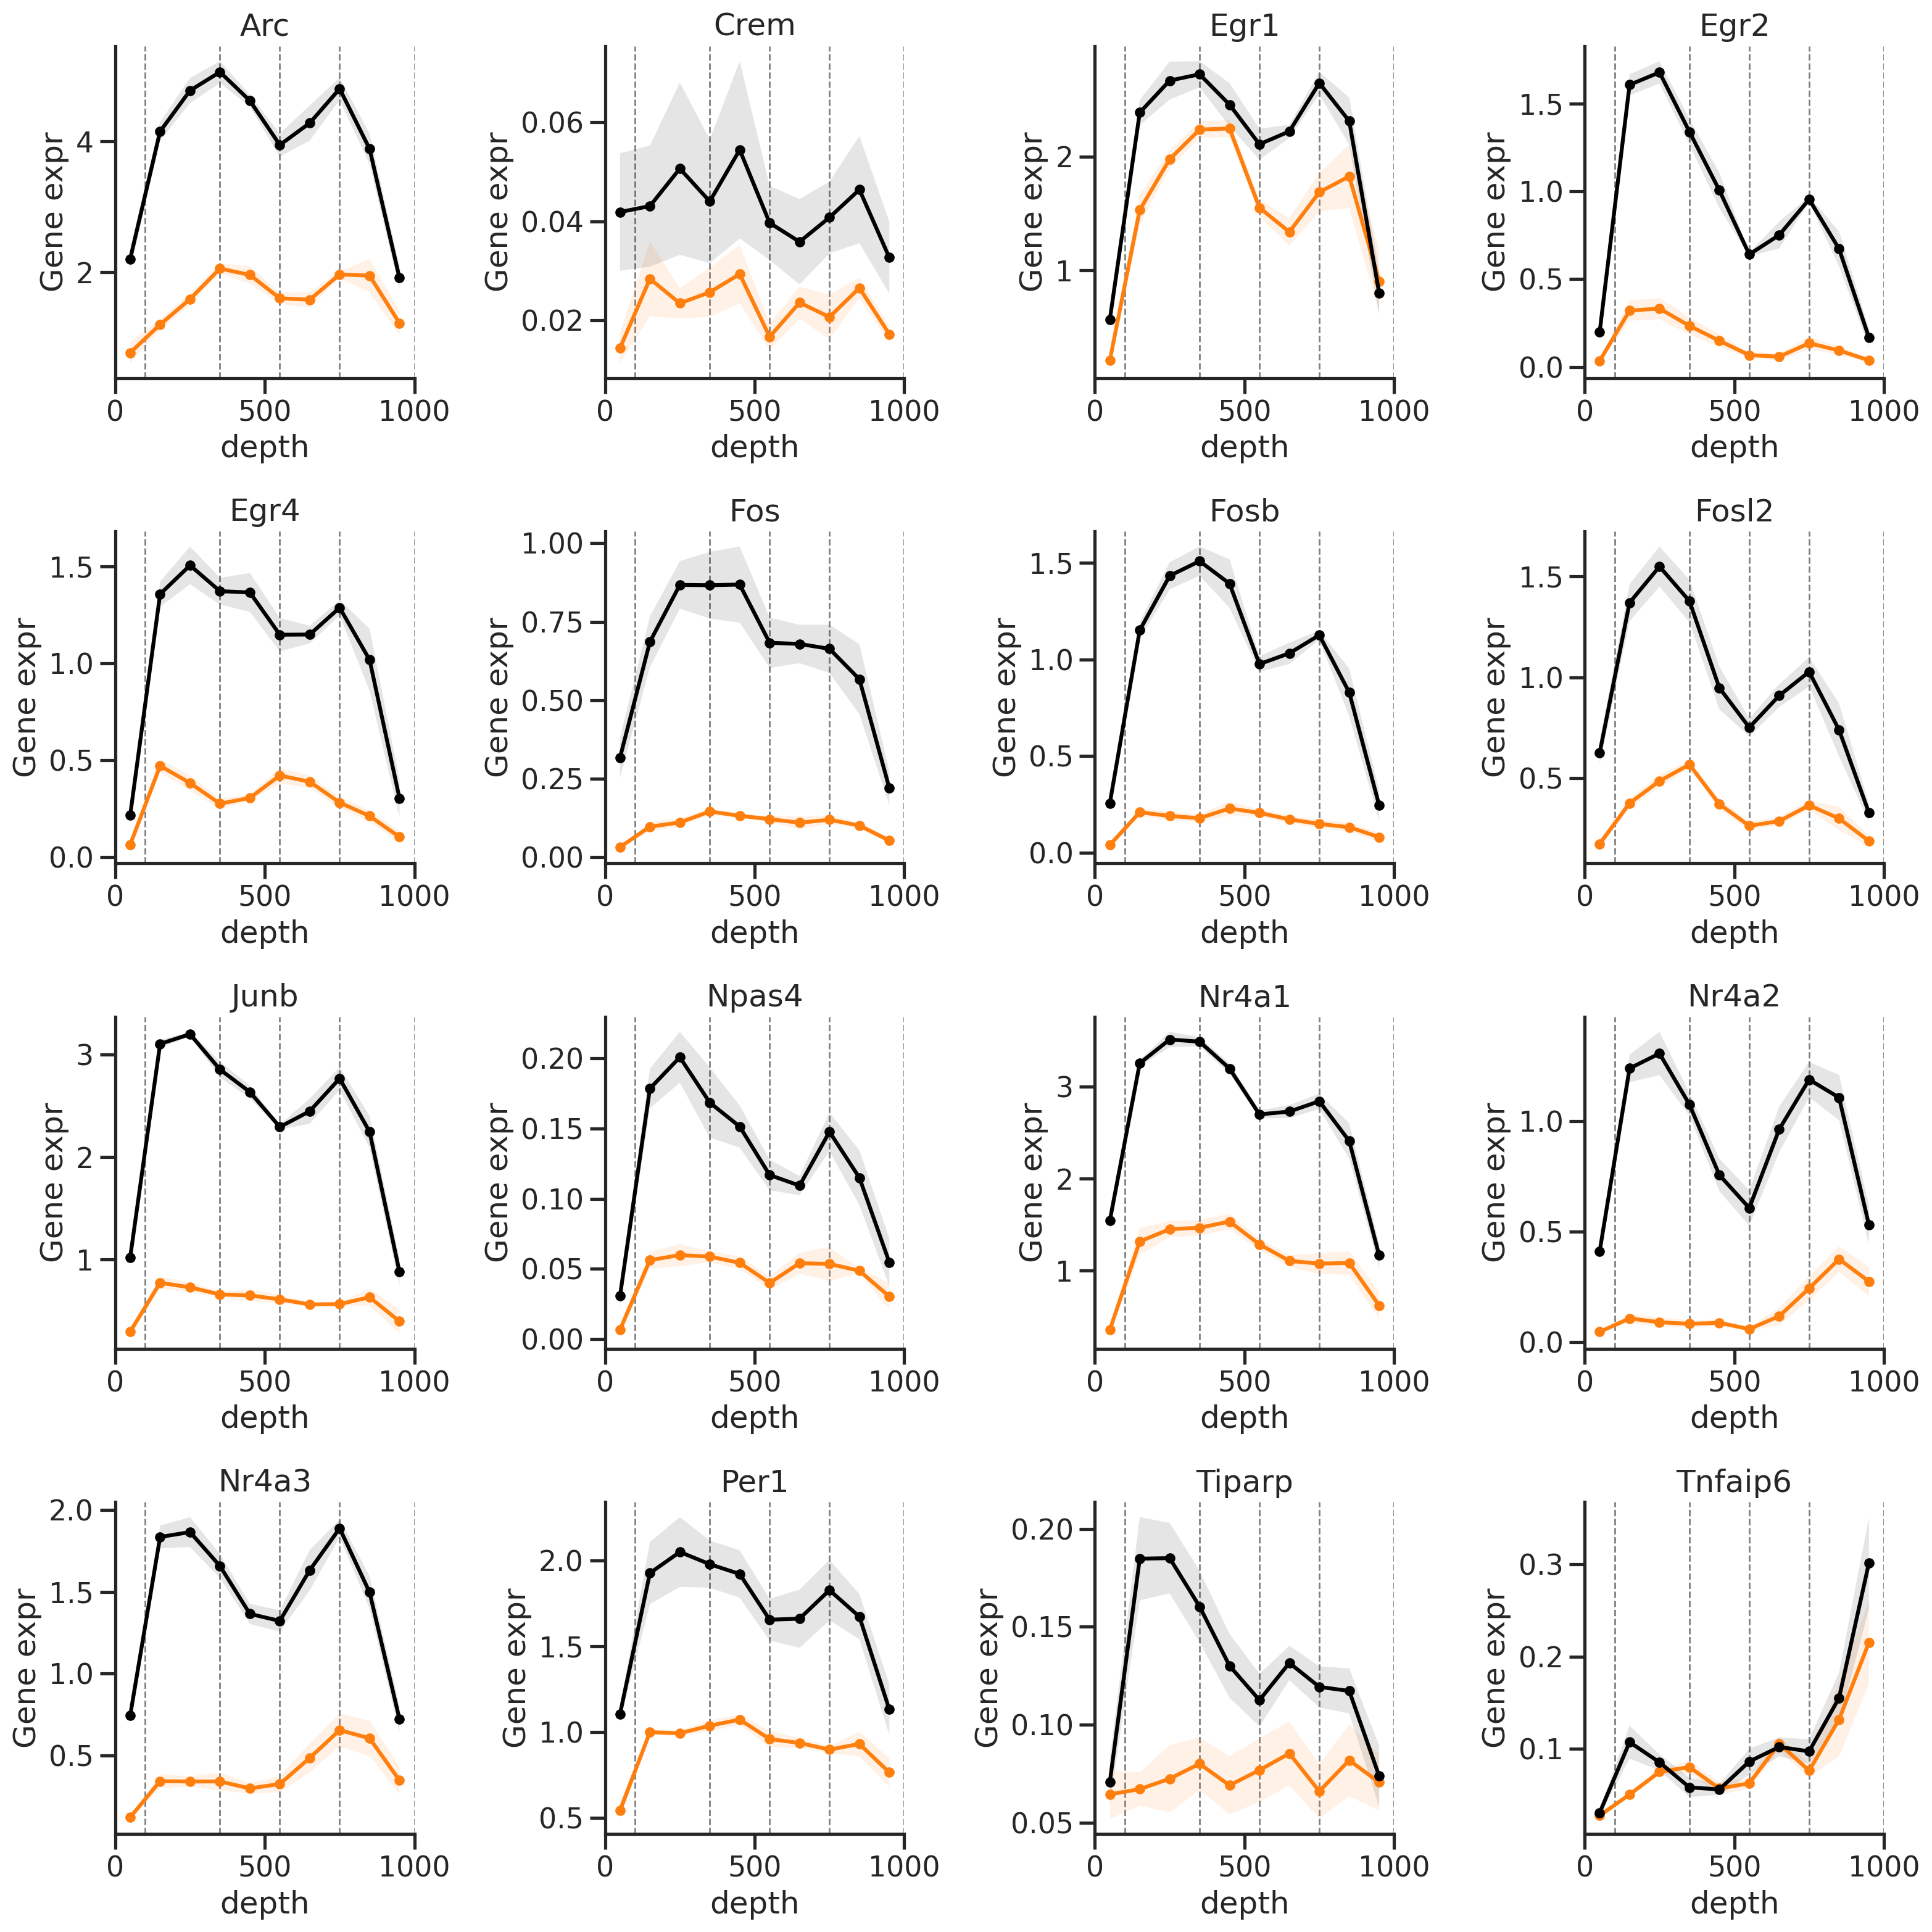

In [35]:
gns = iegs
n = len(gns)
nx = 4
ny = int((n+nx-1)/nx)
fig, axs = plt.subplots(ny,nx,figsize=(nx*4,ny*4))
for i, gn in enumerate(gns):
    gidx = basicu.get_index_from_array(adata.var.index.values, [gn])
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins_depth, mean_nr_dp, sem_nr_dp, mean_dr_dp, sem_dr_dp, gidx, gn)
    ax.set_xticks(np.arange(0,1000+1,500))
    for d in [100,350,550,750,1000]:
        ax.axvline(d, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('depth')
fig.tight_layout()
fig_manager.savefig(fig)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/3_2024-09-10.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/3.pdf


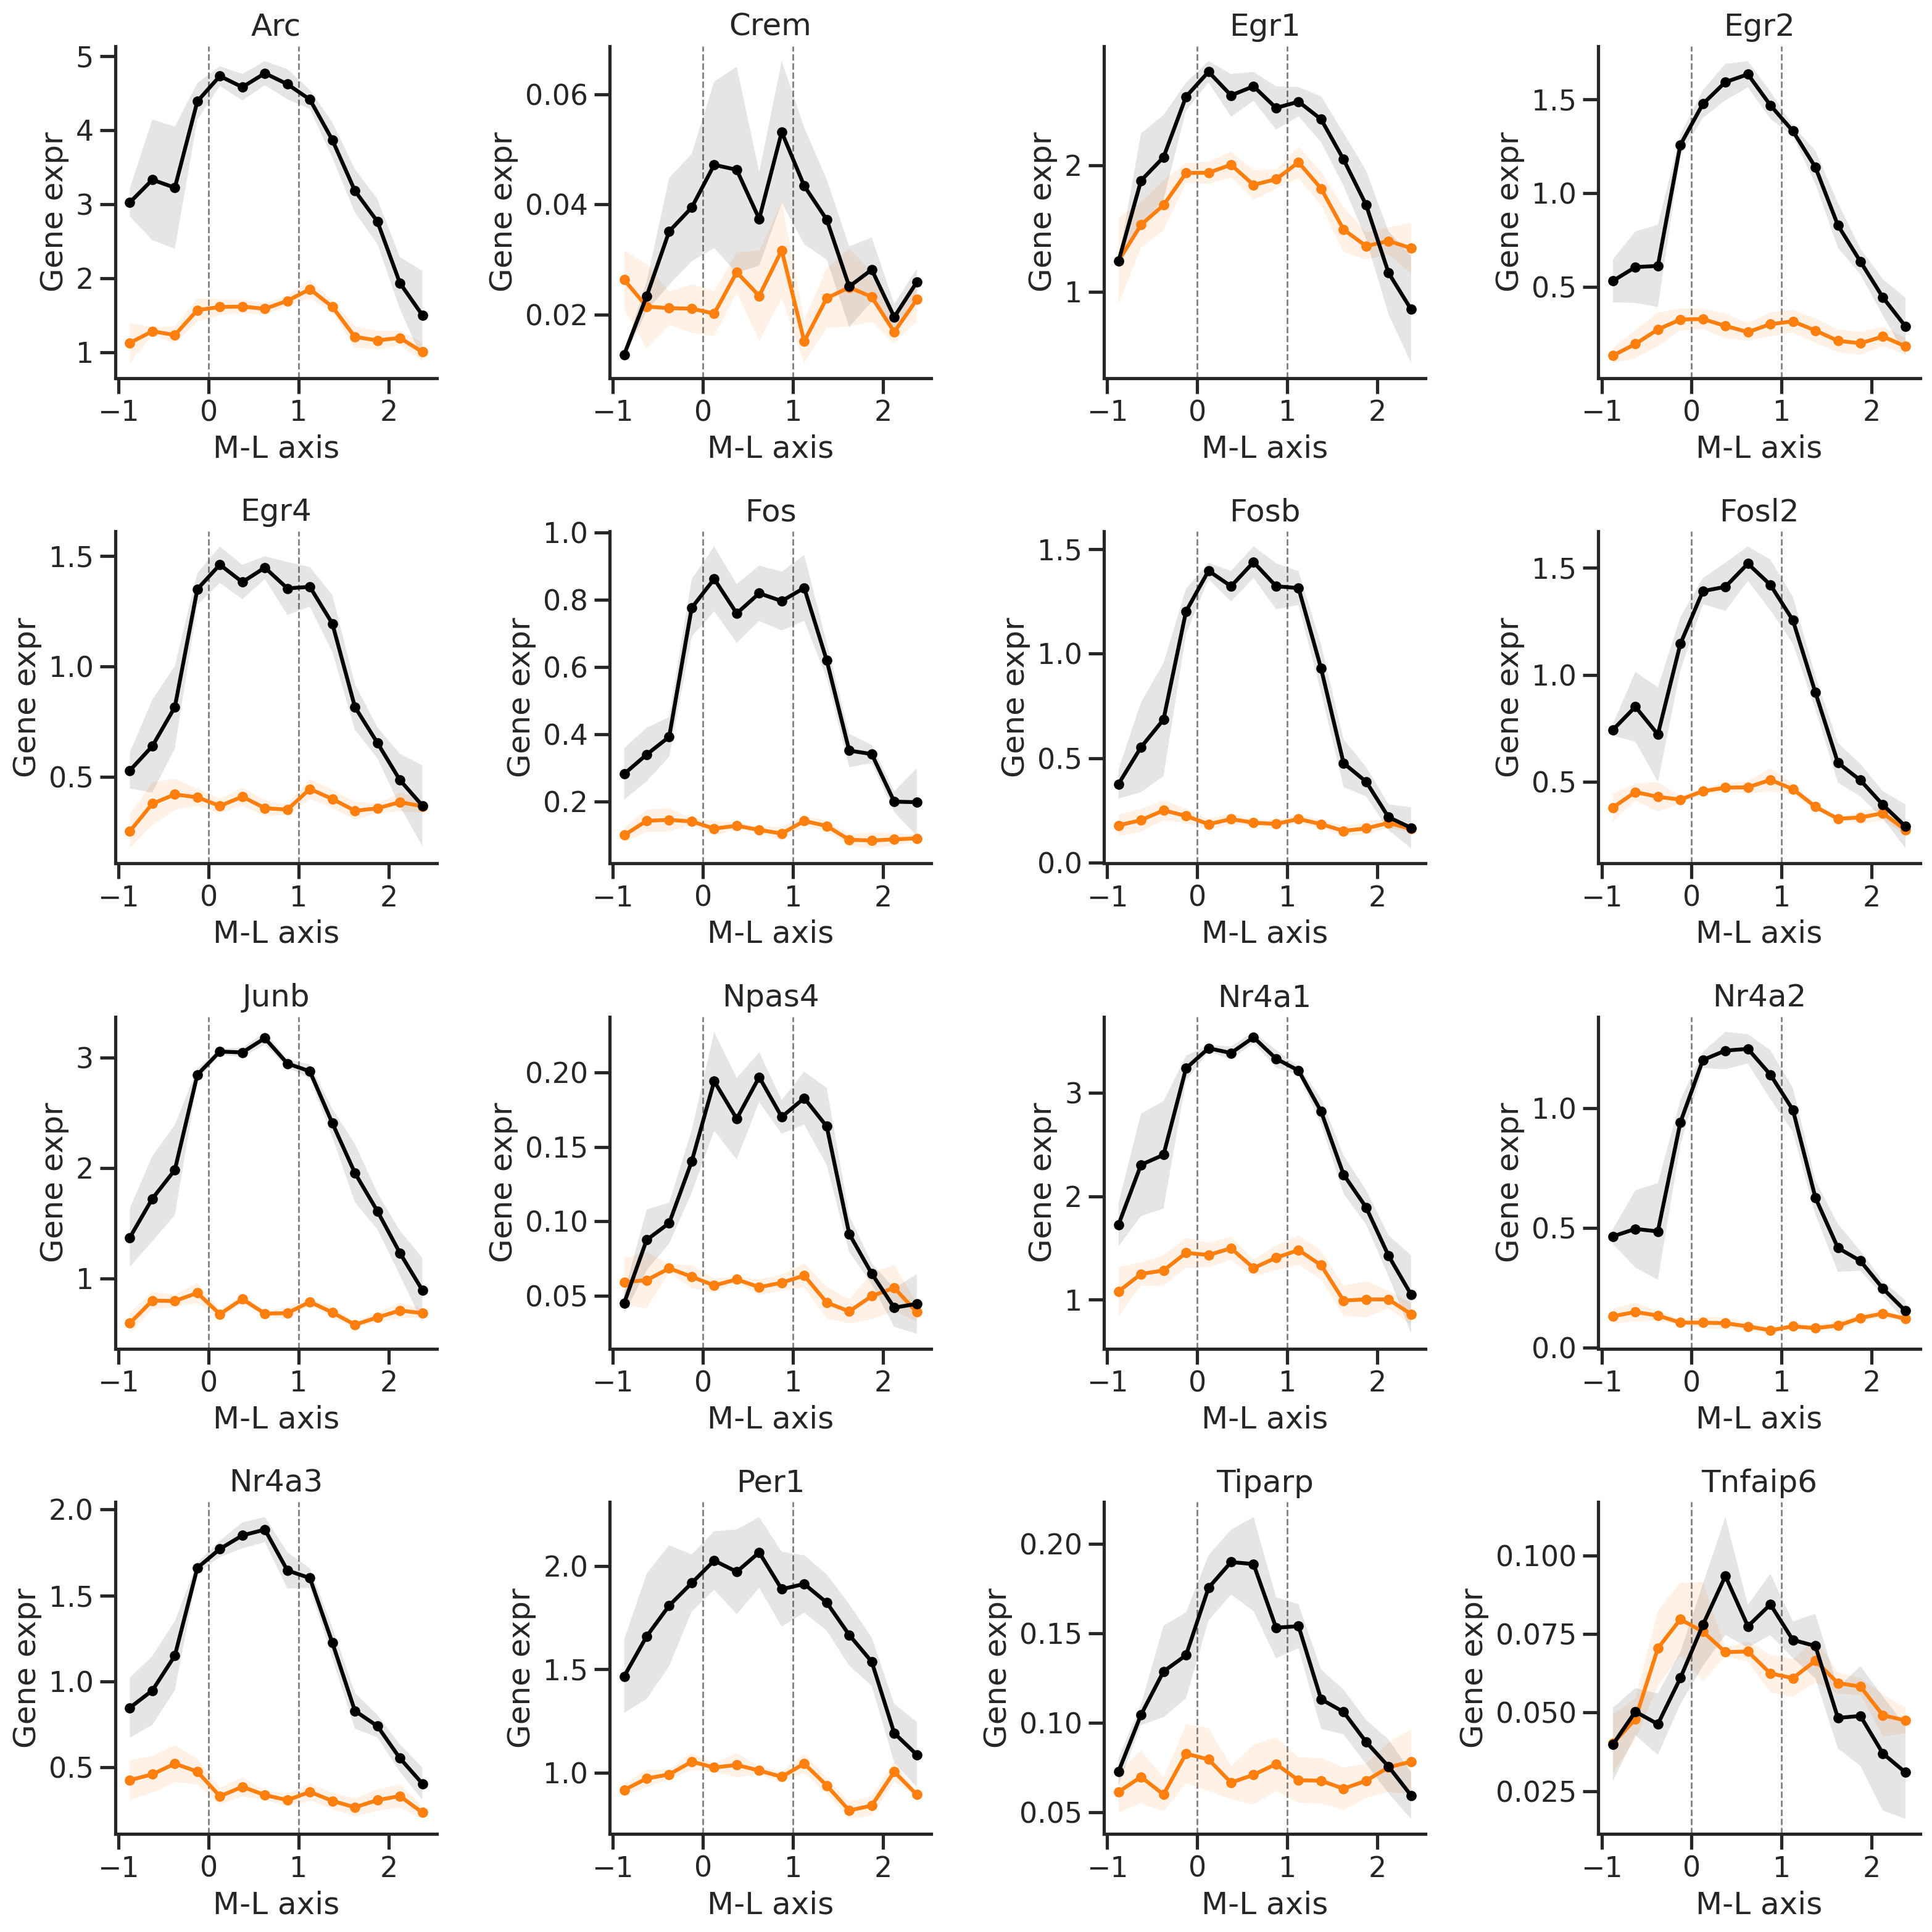

In [36]:
gns = iegs
n = len(gns)
nx = 4
ny = int((n+nx-1)/nx)
fig, axs = plt.subplots(ny,nx,figsize=(nx*4,ny*4))
for i, gn in enumerate(gns):
    gidx = basicu.get_index_from_array(adata.var.index.values, [gn])
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins, mean_nr_l23, sem_nr_l23, mean_dr_l23, sem_dr_l23, gidx, gn)
    ax.set_xticks([-1,0,1,2])
    ax.axvline(0, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.axvline(1, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('M-L axis')
fig.tight_layout()
fig_manager.savefig(fig)
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/4_2024-09-10.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/4.pdf


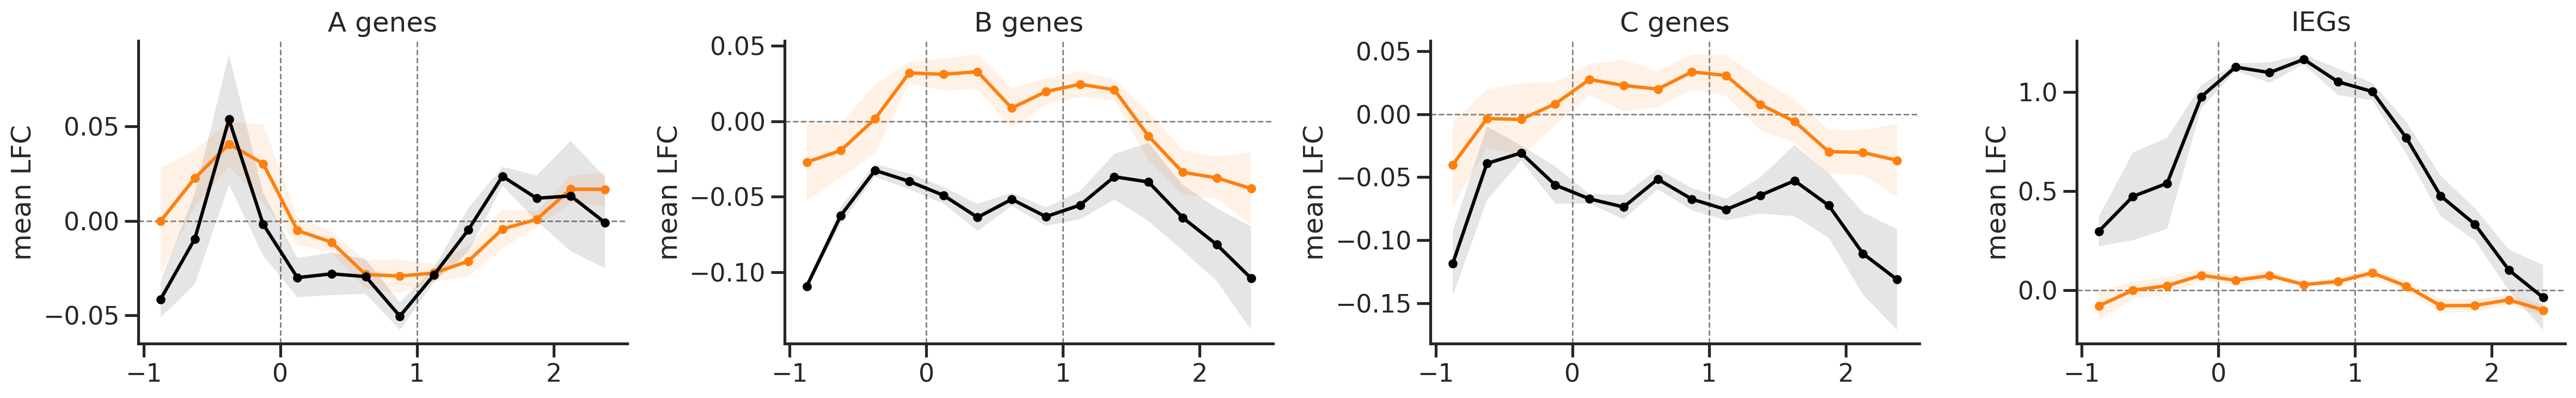

In [37]:
gene_group_names = ['A genes', 'B genes', 'C genes', 'IEGs']

n = len(gene_group_names)
fig, axs = plt.subplots(1,n,figsize=(n*6,4))
for i, gene_group_name in enumerate(gene_group_names):
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins, nr_mfc, nr_sem, dr_mfc, dr_sem, i, gn=gene_group_name)
    ax.set_ylabel('mean LFC')
    ax.set_xticks([-1,0,1,2])
    ax.axvline(0, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.axvline(1, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.axhline(0, linestyle='--', color='gray', zorder=0, linewidth=1)
    
fig.tight_layout()
fig_manager.savefig(fig)
plt.show()
    

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/5_2024-09-10.pdf
/u/home/f/f7xiesnm/project-zipursky/v1-bb/ms_reanalysis/240910-2/5.pdf


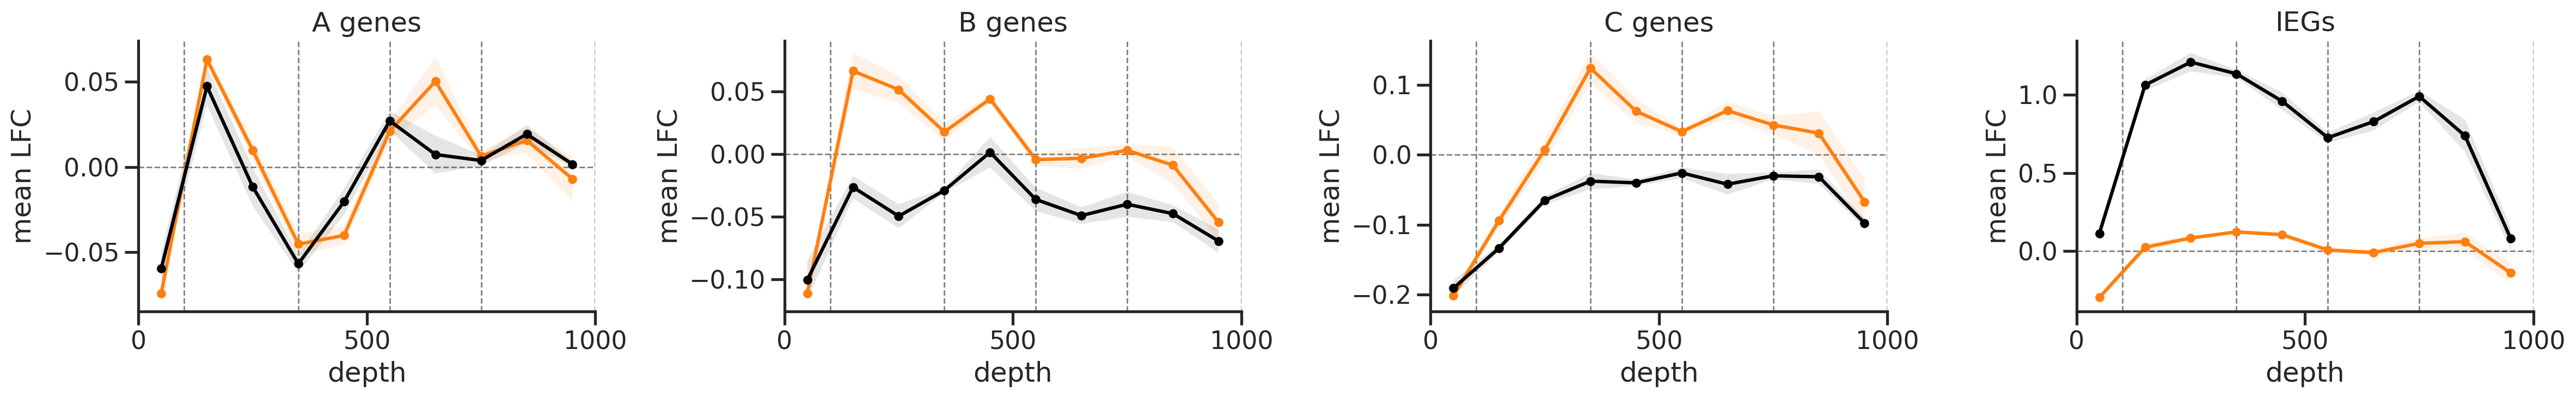

In [38]:
gene_group_names = ['A genes', 'B genes', 'C genes', 'IEGs']

n = len(gene_group_names)
fig, axs = plt.subplots(1,n,figsize=(n*6,4))
for i, gene_group_name in enumerate(gene_group_names):
    ax = axs.flat[i]
    plot_hist_ax(ax, midbins_depth, nr_mfc_dp, nr_sem_dp, dr_mfc_dp, dr_sem_dp, i, gn=gene_group_name)
    ax.set_ylabel('mean LFC')
    ax.set_xticks(np.arange(0,1000+1,500))
    for d in [100,350,550,750,1000]:
        ax.axvline(d, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.axhline(0, linestyle='--', color='gray', zorder=0, linewidth=1)
    ax.set_xlabel('depth')
fig.tight_layout()
fig_manager.savefig(fig)
plt.show()

In [39]:
# small magnitutes may due to lumping together all cells
2**0.05, 2**0.1, 2**1

(1.0352649238413776, 1.0717734625362931, 2)